# Import packages


In [ ]:
#pip install attention
#pip install -i https://pypi.tuna.tsinghua.edu.cn/simple/ --upgrade tensorflow

In [22]:
import glob,os,random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv2D, MaxPooling3D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
#LSTM
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten
import tensorflow as tf
from sklearn.metrics import classification_report
#For resampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from collections import Counter
from keras import backend as K
import tensorflow as tf
from attention import Attention


In [3]:
random.seed(123)

# Data Input

In [4]:
data = pd.read_csv('./ponzi.csv')
data.head()

ID    lifetime  most active  active day  \
0  1LAqeV9NW4tF5yEN5ji49Q8wHFytxgbLiR   2365607.0         17.0        62.0   
1  1FzuVAnLatnLTVWKwST56EH9MUBp83Ceqh  67847480.0        252.0     13443.0   
2  33k4aYErVs24qVhBDp5v9oBg7byA5mwTiH  51608193.0        201.0       129.0   
3   18Rtg39sk9yTeSioKHFEDVpHHjApMFya2       805.0          7.0         2.0   
4  36k4HwemSk2YpZCpxU3YPkDRmThRwy39ZP     21199.0         19.0         7.0   

   in vs out  num out   num in  num addr received  num addr sent  \
0   0.976923     61.0     61.0              127.0          130.0   
1   0.828209  10212.0  10212.0            68902.0        83194.0   
2   1.337990     65.0     65.0             2490.0         1861.0   
3   0.250000      1.0      1.0                2.0            8.0   
4   0.586207      6.0      6.0               17.0           29.0   

   median delay     mean delay  minimum delay  maximum delay  \
0       12943.0   38780.442620            0.0       162725.0   
1         462.0    5047.424490          -25.0      8238795.0   
2       51386.0  403189.007800          487.0      6648665.0   
3         805.0     805.000000          805.0          805.0   
4        2849.0    3533.166667           63.0         8685.0   

   total received BTC  total sent BTC  avg received BTC  avg sent BTC  \
0            1.540411        1.540411          0.025253      0.025253   
1        10084.422480    10084.422480          0.987507      0.987507   
2            0.899271        0.899271          0.013835      0.013835   
3            0.044716        0.044716          0.044716      0.044716   
4            0.144773        0.144773          0.024129      0.024129   

   48 diff  class  
0      4.0      1  
1   -250.0      1  
2    199.0      1  
3     -1.0      1  
4    -17.0      1

In [5]:
data = data.drop(['ID'],axis=1)
print('NA:',data.isnull().sum().max())
data.describe()

NA: 1


lifetime  most active    active day   in vs out       num out  \
count  3.910000e+02   391.000000    391.000000  391.000000    391.000000   
mean   8.771652e+06   186.948849   1043.562660    3.935487    906.803069   
std    2.159142e+07   465.987534   6813.835397   19.522099   5875.897868   
min    0.000000e+00     2.000000      2.000000    0.020534      0.000000   
25%    5.547960e+05     7.000000      5.000000    0.263736      3.000000   
50%    1.143830e+06    42.000000      8.000000    0.656250      4.000000   
75%    3.454262e+06   123.000000     18.000000    1.200000     17.000000   
max    1.850799e+08  3002.000000  82800.000000  245.000000  63150.000000   

             num in  num addr received  num addr sent  median delay  \
count    391.000000       3.910000e+02   3.910000e+02  3.910000e+02   
mean     881.214834       8.307826e+03   9.641742e+03  2.709277e+05   
std     5812.662827       9.216555e+04   1.043211e+05  1.407727e+06   
min        1.000000       2.000000e+00   2.000000e+00  0.000000e+00   
25%        3.000000       1.200000e+01   1.000000e+01  1.365700e+04   
50%        6.000000       2.400000e+01   5.300000e+01  4.383600e+04   
75%       17.000000       6.900000e+01   1.790000e+02  9.676500e+04   
max    74719.000000       1.767354e+06   1.998305e+06  1.557204e+07   

         mean delay  minimum delay  maximum delay  total received BTC  \
count  3.910000e+02   3.910000e+02   3.910000e+02          391.000000   
mean   4.532658e+05   2.211277e+05   3.164227e+06         4289.186125   
std    1.476688e+06   1.414079e+06   8.885505e+06        44409.651666   
min    0.000000e+00  -9.489320e+05   0.000000e+00            0.000000   
25%    8.245569e+04   0.000000e+00   2.665385e+05            0.261118   
50%    1.681990e+05   1.383000e+03   6.971950e+05            0.488999   
75%    2.613584e+05   4.748600e+04   1.080465e+06            1.490257   
max    1.557204e+07   1.557204e+07   6.888818e+07       623015.144500   

       total sent BTC  avg received BTC  avg sent BTC      48 diff       class  
count      391.000000        391.000000    391.000000   391.000000  392.000000  
mean      3779.471909          4.368480      4.526490   -79.421995    0.346939  
std      37618.883425         44.937251     45.007774   487.005395    0.476604  
min          0.000369          0.000000      0.000281 -3000.000000    0.000000  
25%          0.261118          0.076122      0.086272   -52.000000    0.000000  
50%          0.556050          0.113085      0.113085    -1.000000    0.000000  
75%          2.145192          0.140561      0.140561     5.000000    1.000000  
max     559547.264200        800.004361    800.004361   961.000000    1.000000

In [6]:
labelname = 'class'

In [7]:
print("bitcoin data set dimensions : {}".format(data.shape))

bitcoin data set dimensions : (392, 18)


In [8]:
data.groupby(labelname).size()

class
0    256
1    136
dtype: int64

# LSTM model

In [9]:
def lstm_model(train_x):
  myLSTM = Sequential()
  myLSTM.add(LSTM(8,return_sequences = True,dropout = 0.1,recurrent_dropout = 0.1,input_shape = train_x.shape[1:]))
  myLSTM.add(LSTM(8,return_sequences = True,dropout = 0.1,recurrent_dropout = 0.2))
  myLSTM.add(Dense(16))
  myLSTM.add(LSTM(16,return_sequences = True,dropout = 0.1,recurrent_dropout = 0.2))
  myLSTM.add(Dense(16))
  myLSTM.add(LSTM(16,return_sequences = True,dropout = 0.2,recurrent_dropout = 0.2))
  myLSTM.add(Attention(20))
  myLSTM.add(Dense(32,activation = 'relu'))
  myLSTM.add(Dropout(0.2))
  myLSTM.add(Flatten())
  myLSTM.add(Dense(2,activation = 'softmax')) #output layer
  myLSTM.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
  tf.keras.utils.plot_model(myLSTM,show_shapes=True)#to_file = results_dir+"LSTM_attention_model.png",show_shapes=Trues
  return myLSTM

In [10]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
standardscaler = StandardScaler()

In [11]:
def get_traintest(data,labelname): # normalization + split train & test
  # drop all NA and inf
  data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  #split train/test by test size = 0.2
  train, test = train_test_split(data, test_size = 0.2, random_state=42)
  # Get train x/y and test x/y
  train_x = train.drop([labelname],axis=1)
  train_y = train[labelname]
  test_x = test.drop([labelname],axis=1)
  test_y = test[labelname]
  #normalization
  train_x = standardscaler.fit_transform(train_x)
  train_x = minmaxscaler.fit_transform(train_x)
  test_x = standardscaler.fit_transform(test_x)
  test_x = minmaxscaler.fit_transform(test_x)
  #reshape and get input of LSTM model
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  return train_x,train_y,test_x,test_y,train, test

In [12]:
train_x,train_y,test_x,test_y,train, test = get_traintest(data,labelname)

In [15]:
myLSTM = lstm_model(train_x)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
myLSTM

In [24]:
help(LSTM)

Help on class LSTM in module keras.layers.rnn.lstm:

class LSTM(keras.layers.rnn.dropout_rnn_cell_mixin.DropoutRNNCellMixin, keras.layers.rnn.base_rnn.RNN, keras.engine.base_layer.BaseRandomLayer)
 |  LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, time_major=False, unroll=False, **kwargs)
 |  
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  See [the Keras RNN API guide](https://www.tensorflow.org/guide/keras/rnn)
 |  for details about the usage of RNN API.
 |  
 |  Based on available runtime hardware and constraints, this layer
 |  will

In [19]:
yaht,ans = myLSTM(myLSTM,train_x,train_y,test_x,test_y,392)

TypeError: Inputs to a layer should be tensors. Got: <keras.engine.sequential.Sequential object at 0x0000020310749F90>

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
#
# Get the predictions
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=test_y, y_pred=yaht)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5),dpi=301)
ax.matshow(conf_matrix, cmap=plt.cm.viridis, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

NameError: name 'yaht' is not defined

In [ ]:
metrics = ['Accuracy','sensitivity','specificity','positive prediction ratio','negative prediction ratio','F1 score','d-index']

In [ ]:
result_lstm = []

In [ ]:
np.save(results_dir+'result_ponzi',np.array(ans))

In [ ]:
results_df = pd.DataFrame(data=ans, index=metrics, columns=['metric'])

In [ ]:
results_df

metric
Accuracy                   0.815249
sensitivity                0.863291
specificity                0.749129
positive prediction ratio  0.825666
negative prediction ratio  0.799257
F1 score                   0.844059
d-index                    1.713133

In [ ]:
result_lstm.append(ans)

# resampling

In [20]:
def computeDataEntropy(x_mat):
    # compute the singular value via svd
    s = np.linalg.svd(x_mat, compute_uv=False)
    mat_entropy= np.log2(np.inner(s, np.log2(1+s)))
    return mat_entropy

In [21]:
method=['RandomOverSampler', 'SMOTE', 'SMOTEENN', 'SMOTETomek','TomekLinks']
train_set = []
for e in method:
  train_label = train[labelname]
  train0 = train.drop([labelname],axis=1)
  print(e)
  print('-------------------------------------')
  data_res, label_res=doResamapling(train0, train_label, e)
  
  t=Counter(label_res)
  major_ratio=t[0]/(t[0]+t[1])
  print('The majority type ratio {:.2f}%'.format(major_ratio*100))
  print(t[0], t[1])
  entropy=computeDataEntropy(data_res)
  print('The train data entropy after'+e+ '{:3.4f}'.format(entropy))
  res_df = pd.DataFrame(data = data_res, columns=train0.columns)
  res_df[labelname]=label_res  
  train_set.append(res_df)

RandomOverSampler
-------------------------------------
The majority type ratio 50.00%
2802 2802
The train data entropy afterRandomOverSampler38.0021
SMOTE
-------------------------------------
The majority type ratio 50.00%
2802 2802
The train data entropy afterSMOTE37.9720
SMOTEENN
-------------------------------------
The majority type ratio 38.80%
975 1538
The train data entropy afterSMOTEENN37.5878
SMOTETomek
-------------------------------------
The majority type ratio 47.88%
2298 2501
The train data entropy afterSMOTETomek37.9138
TomekLinks
-------------------------------------
The majority type ratio 90.02%
1976 219
The train data entropy afterTomekLinks37.5474


In [22]:
def get_newtraintest(train,test):
  train_x = train.drop([labelname],axis=1)
  train_y = train[labelname]
  test_x = test.drop([labelname],axis=1)
  test_y = test[labelname]
  train_x = standardscaler.fit_transform(train_x)
  train_x = minmaxscaler.fit_transform(train_x)
  test_x = standardscaler.fit_transform(test_x)
  test_x = minmaxscaler.fit_transform(test_x)
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  return train_x,train_y,test_x,test_y

RandomOverSampler
-----------------------------------------------
Train on 8406 samples, validate on 1364 samples
Epoch 1/2000
8406/8406 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.5399

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8406/8406 [==============================] - 13s 1ms/sample - loss: 0.9751 - accuracy: 0.5399 - val_loss: 1.5803 - val_accuracy: 0.0484
Epoch 2/2000
8406/8406 [==============================] - 4s 443us/sample - loss: 1.1430 - accuracy: 0.3513 - val_loss: 1.5483 - val_accuracy: 0.0484
Epoch 3/2000
8406/8406 [==============================] - 4s 435us/sample - loss: 1.1656 - accuracy: 0.3060 - val_loss: 1.2281 - val_accuracy: 0.0484
Epoch 4/2000
8406/8406 [==============================] - 4s 442us/sample - loss: 1.1098 - accuracy: 0.3677 - val_loss: 1.2754 - val_accuracy: 0.0484
Epoch 5/2000
8406/8406 [==============================] - 4s 425us/sample - loss: 1.1327 - accuracy: 0.2796 - val_loss: 1.2163 - val_accuracy: 0.0484
Epoch 6/2000
8406/8406 [==============================] - 4s 423us/sample - loss: 1.1163 - accuracy: 0.3352 - val_loss: 1.2344 - val_accuracy: 0.0484
Epoch 7/2000
8406/8406 [==============================] - 4s 425us/sample - loss: 1.0560 - accuracy: 0.4549 - val_

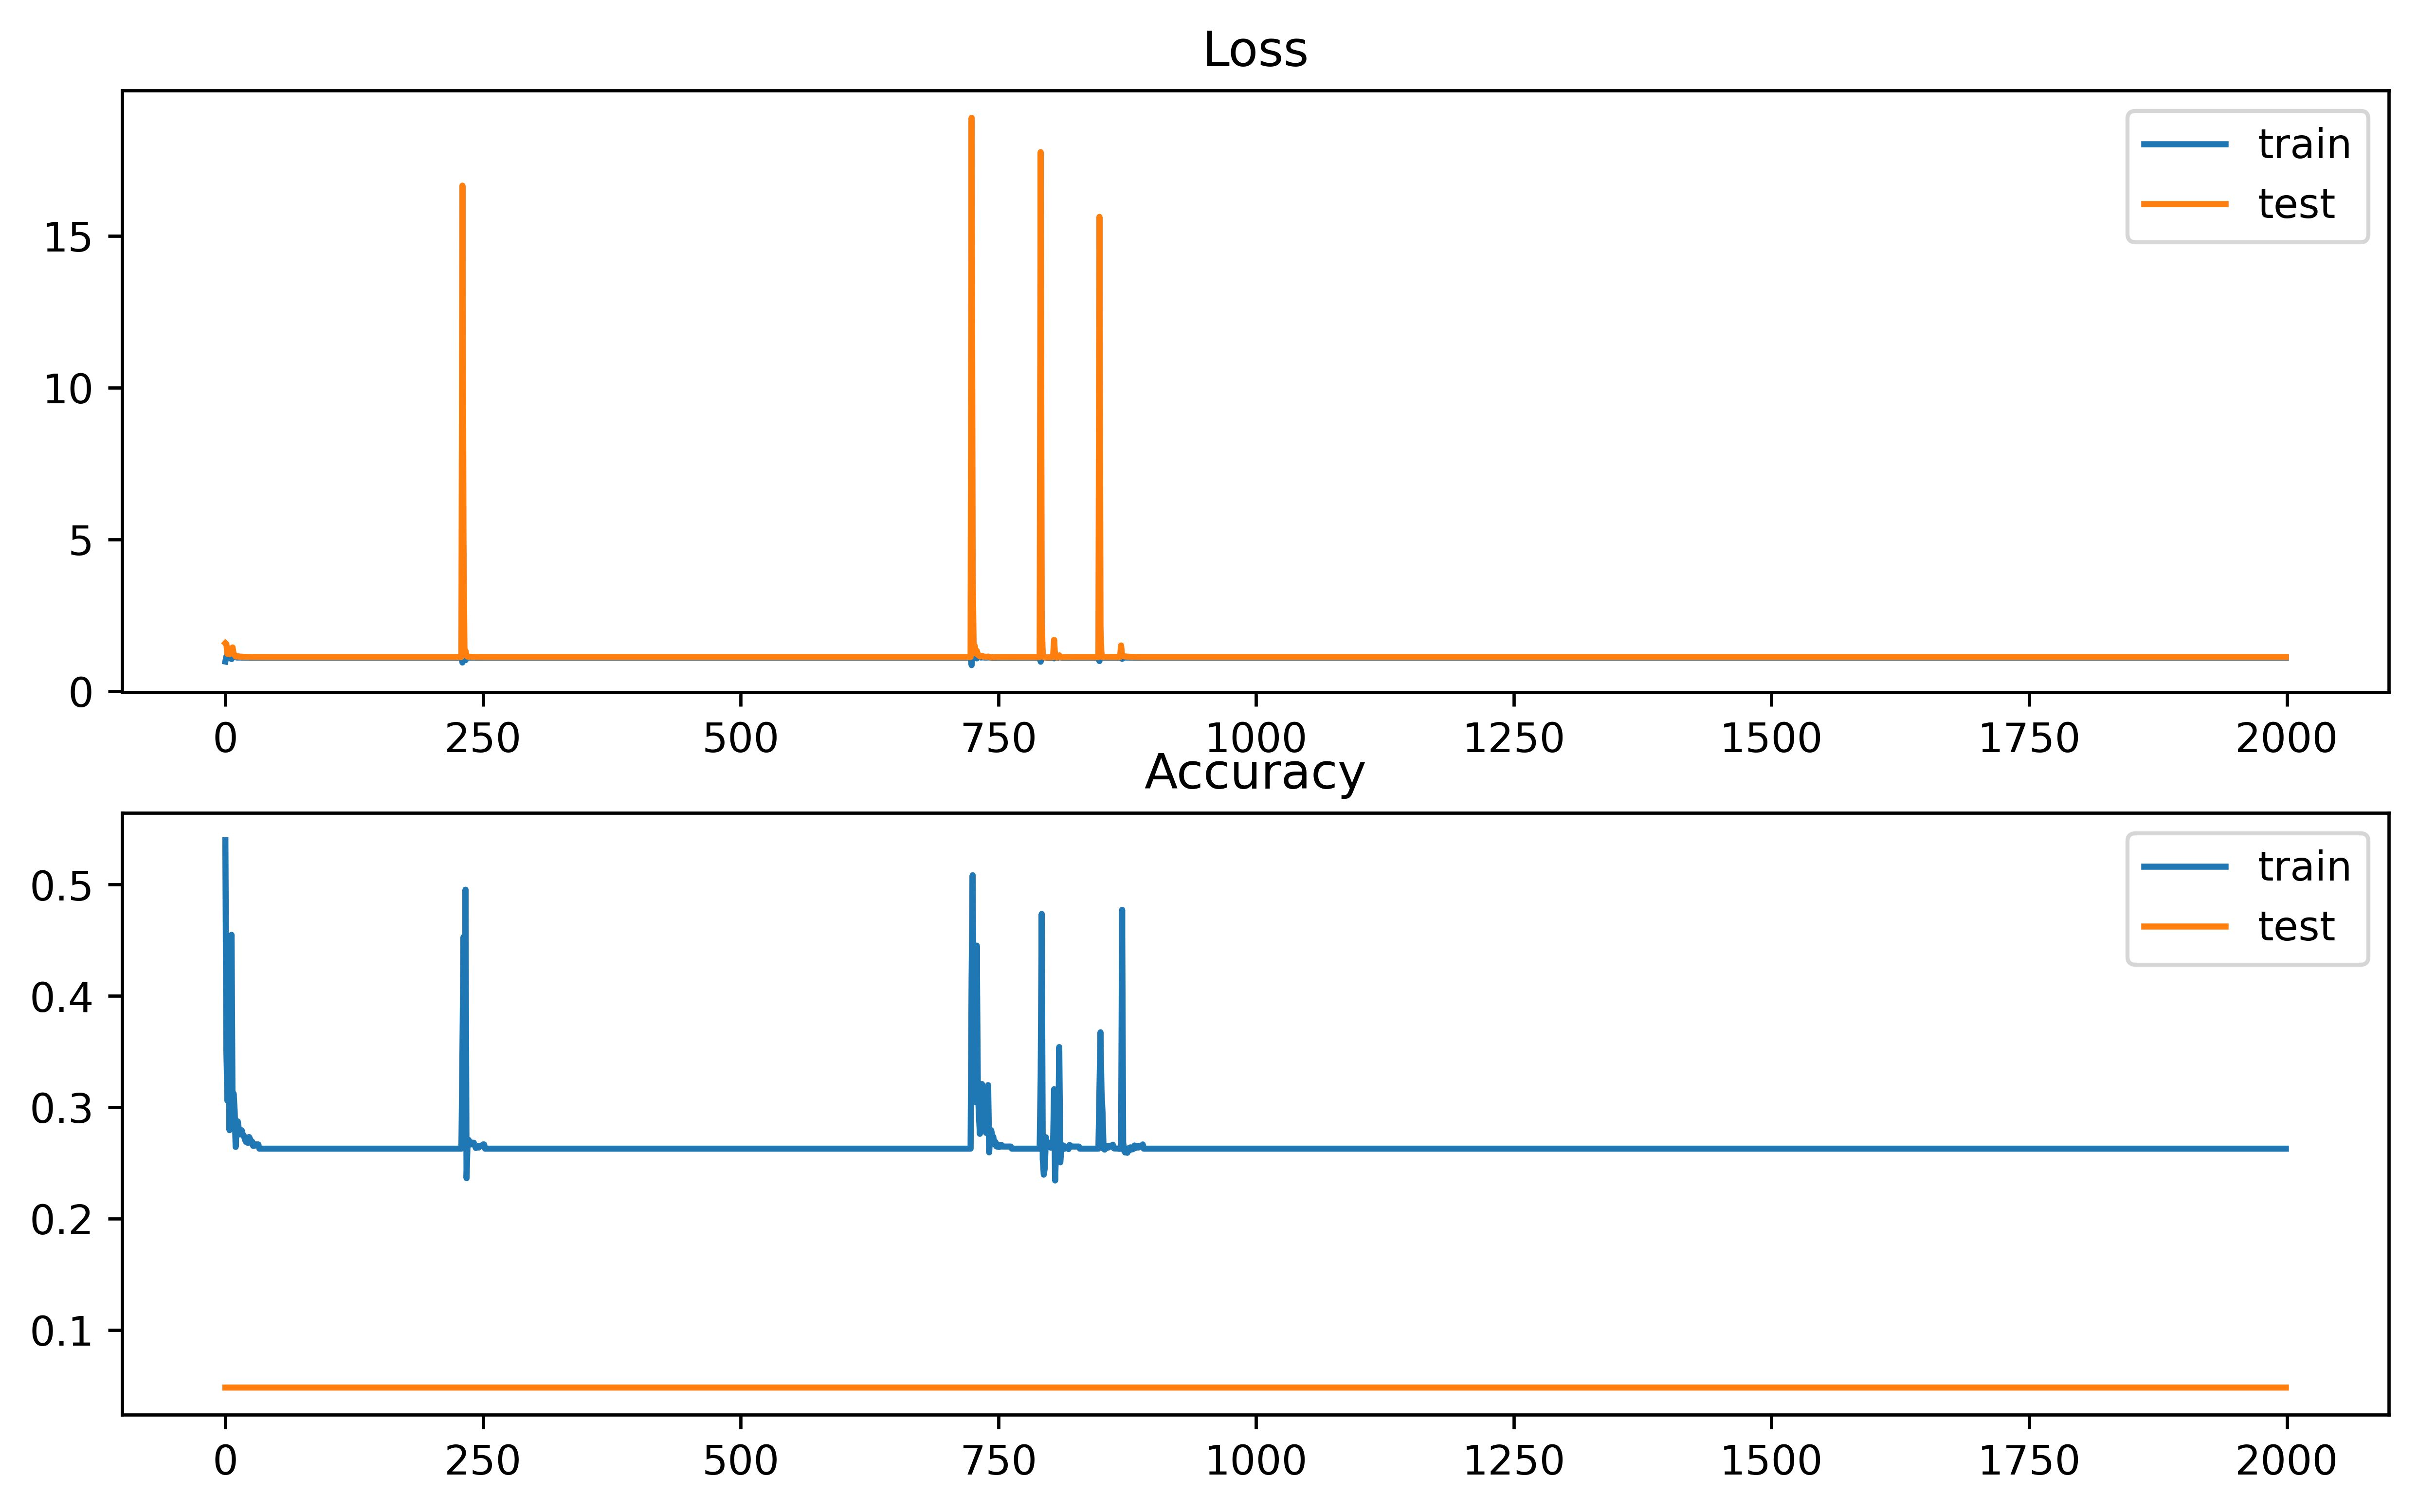

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 4.84%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       574
           1       0.05      1.00      0.09        66
           2       0.00      0.00      0.00       724

    accuracy                           0.05      1364
   macro avg       0.02      0.33      0.03      1364
weighted avg       0.00      0.05      0.00      1364

diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
[0.04838709677419355, 0.08354430379746836, 0.0, 0.103125, 0.0, 0.09230769230769231, 0.12721127999873966]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------
SMOTE
-----------------------------------------------
Train on 8406 samples, validate on 1364 samples
Epoch 1/2000
8352/8406 [============================>.] - ETA: 0s - loss: 0.9405 - accuracy: 0.5426

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8406/8406 [==============================] - 15s 2ms/sample - loss: 0.9354 - accuracy: 0.5456 - val_loss: 2.9782 - val_accuracy: 0.0484
Epoch 2/2000
8406/8406 [==============================] - 3s 407us/sample - loss: 1.2058 - accuracy: 0.3293 - val_loss: 1.4945 - val_accuracy: 0.0484
Epoch 3/2000
8406/8406 [==============================] - 3s 414us/sample - loss: 1.1633 - accuracy: 0.2234 - val_loss: 1.1176 - val_accuracy: 0.0484
Epoch 4/2000
8406/8406 [==============================] - 4s 422us/sample - loss: 1.0573 - accuracy: 0.4095 - val_loss: 1.8150 - val_accuracy: 0.0484
Epoch 5/2000
8406/8406 [==============================] - 3s 411us/sample - loss: 1.1495 - accuracy: 0.3511 - val_loss: 1.4455 - val_accuracy: 0.0484
Epoch 6/2000
8406/8406 [==============================] - 3s 415us/sample - loss: 1.1413 - accuracy: 0.3105 - val_loss: 1.2811 - val_accuracy: 0.0484
Epoch 7/2000
8406/8406 [==============================] - 3s 407us/sample - loss: 1.0800 - accuracy: 0.4066 - val_

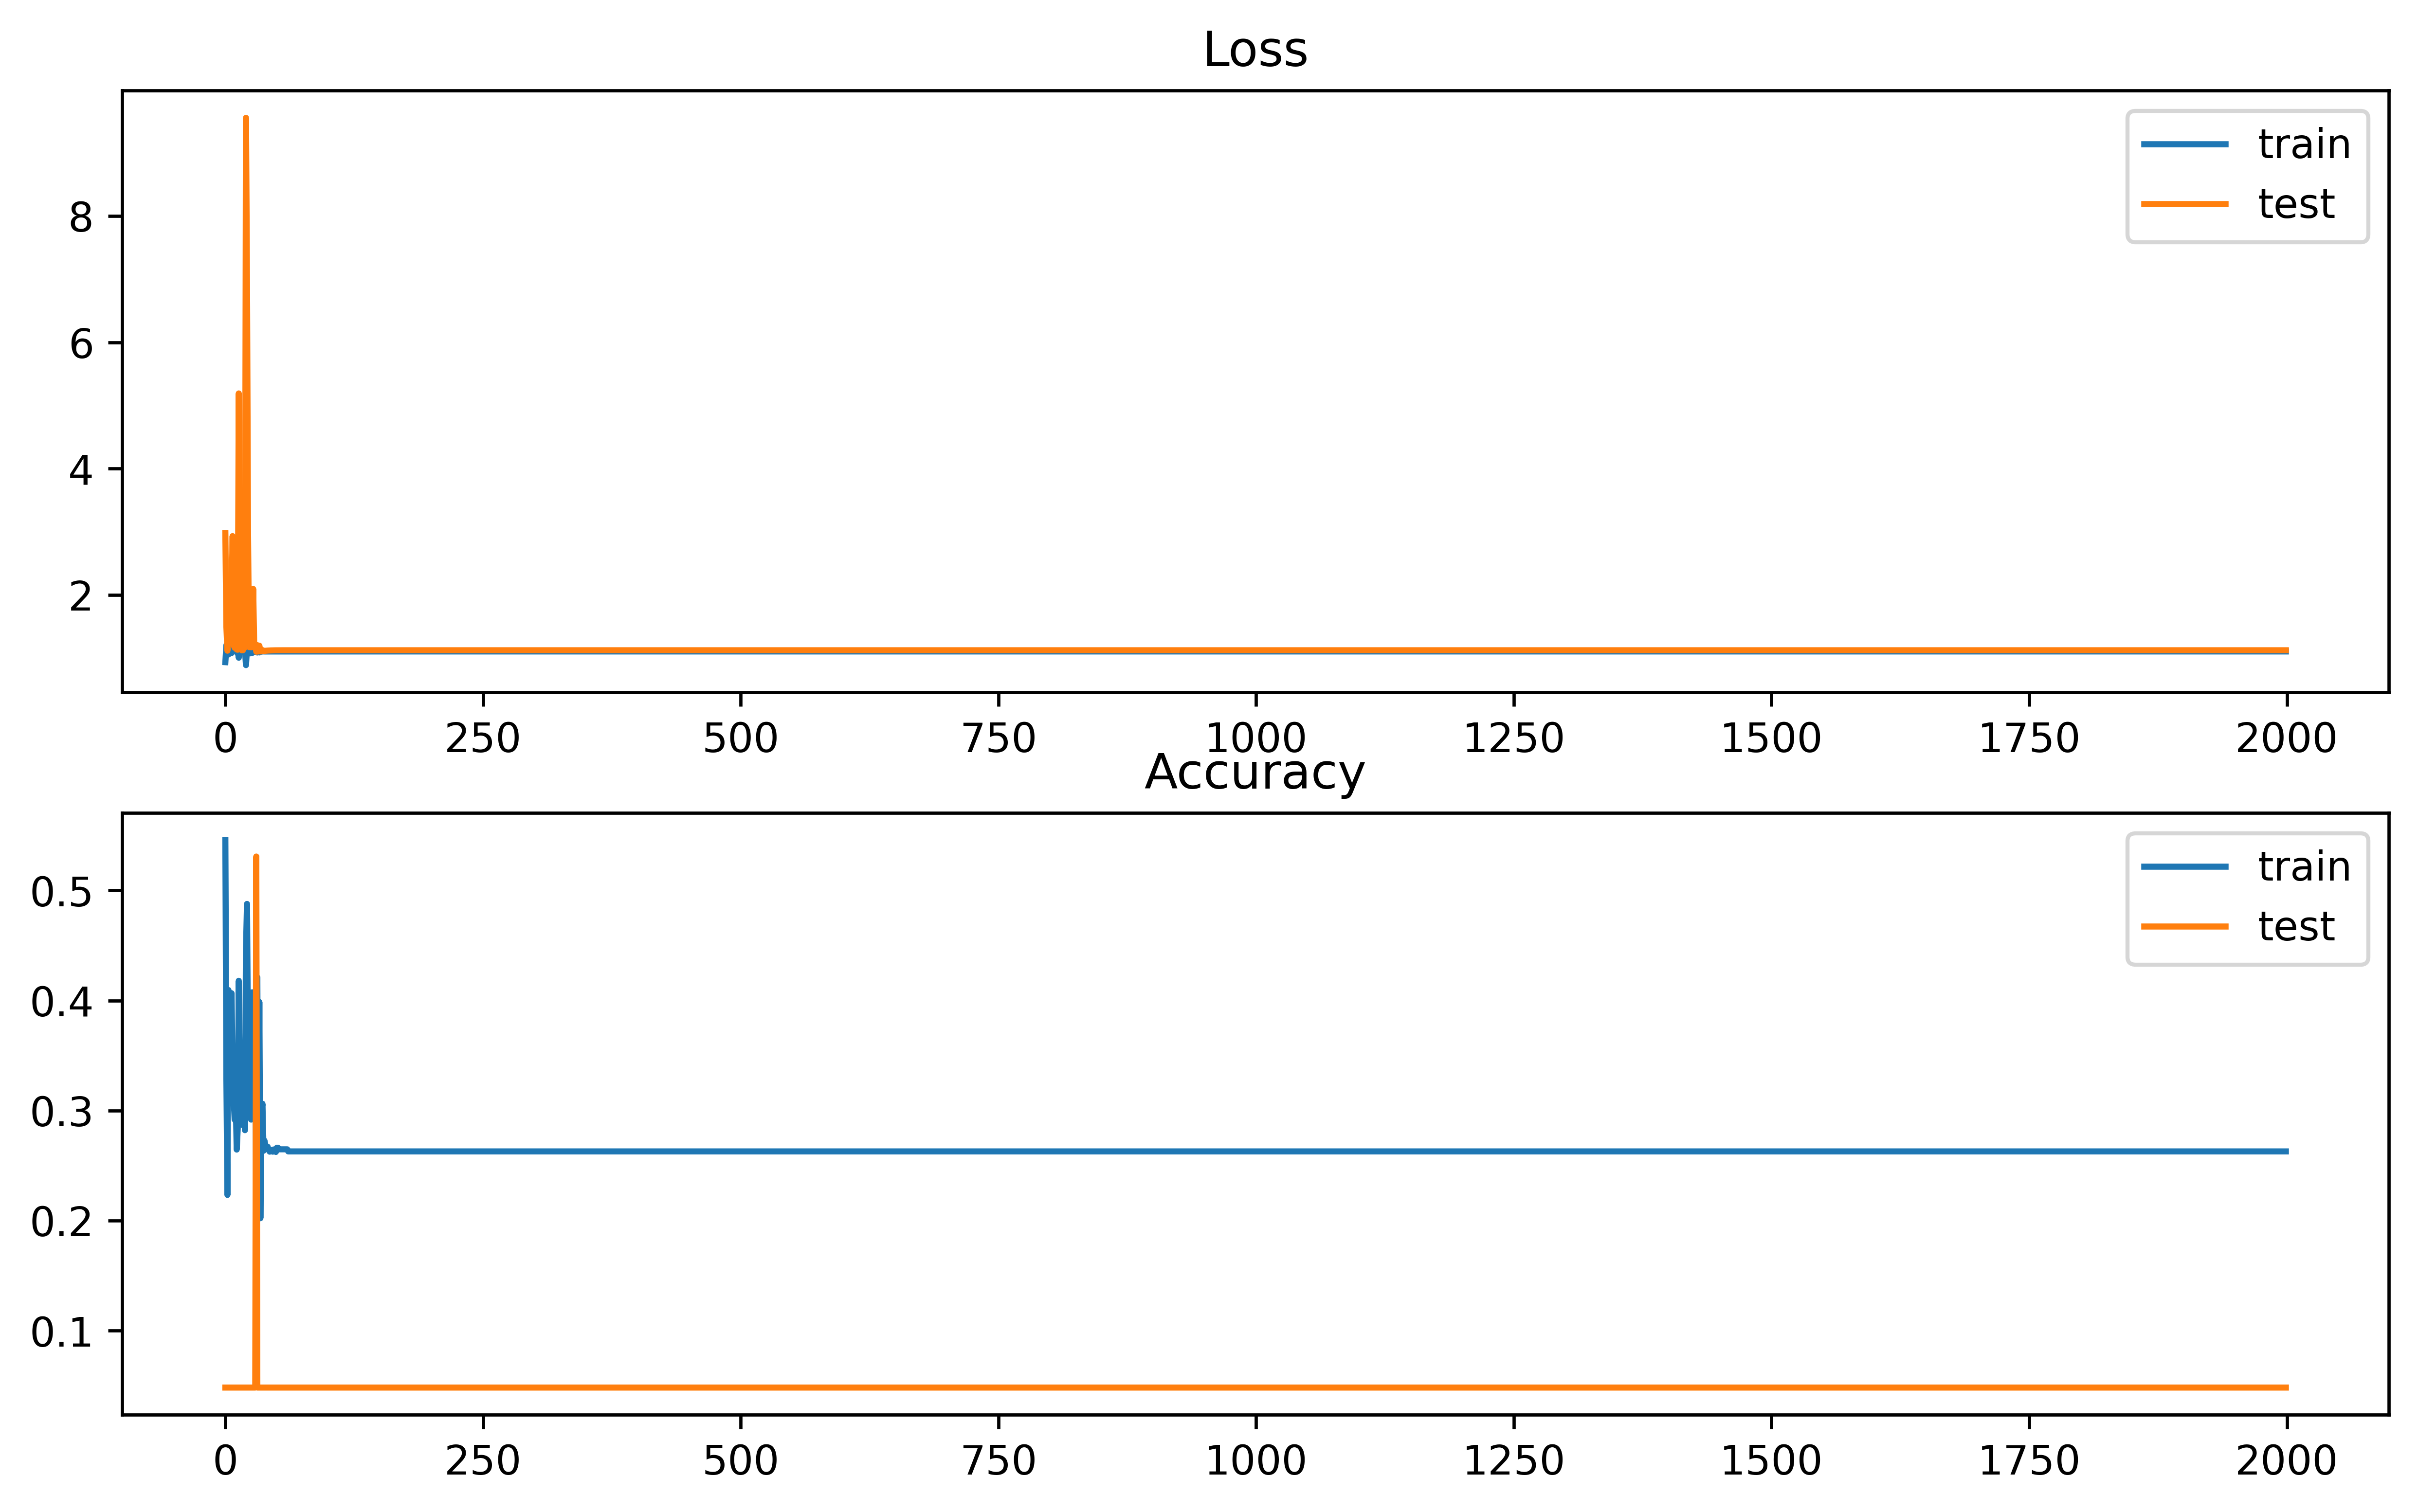

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 4.84%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       574
           1       0.05      1.00      0.09        66
           2       0.00      0.00      0.00       724

    accuracy                           0.05      1364
   macro avg       0.02      0.33      0.03      1364
weighted avg       0.00      0.05      0.00      1364

diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
[0.04838709677419355, 0.08354430379746836, 0.0, 0.103125, 0.0, 0.09230769230769231, 0.12721127999873966]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------
SMOTEENN
-----------------------------------------------
Train on 3532 samples, validate on 1364 samples
Epoch 1/2000
3532/3532 [==============================] - ETA: 0s - loss: 1.1380 - accuracy: 0.3103

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3532/3532 [==============================] - 21s 6ms/sample - loss: 1.1380 - accuracy: 0.3103 - val_loss: 1.1175 - val_accuracy: 0.0484
Epoch 2/2000
3532/3532 [==============================] - 2s 533us/sample - loss: 1.1879 - accuracy: 0.4652 - val_loss: 1.2096 - val_accuracy: 0.0484
Epoch 3/2000
3532/3532 [==============================] - 2s 546us/sample - loss: 1.1242 - accuracy: 0.4071 - val_loss: 1.1794 - val_accuracy: 0.0484
Epoch 4/2000
3532/3532 [==============================] - 2s 573us/sample - loss: 1.1127 - accuracy: 0.4354 - val_loss: 1.1827 - val_accuracy: 0.0484
Epoch 5/2000
3532/3532 [==============================] - 2s 608us/sample - loss: 1.1072 - accuracy: 0.4354 - val_loss: 1.1913 - val_accuracy: 0.0484
Epoch 6/2000
3532/3532 [==============================] - 2s 558us/sample - loss: 1.1057 - accuracy: 0.4354 - val_loss: 1.1964 - val_accuracy: 0.0484
Epoch 7/2000
3532/3532 [==============================] - 2s 532us/sample - loss: 1.1043 - accuracy: 0.4354 - val_

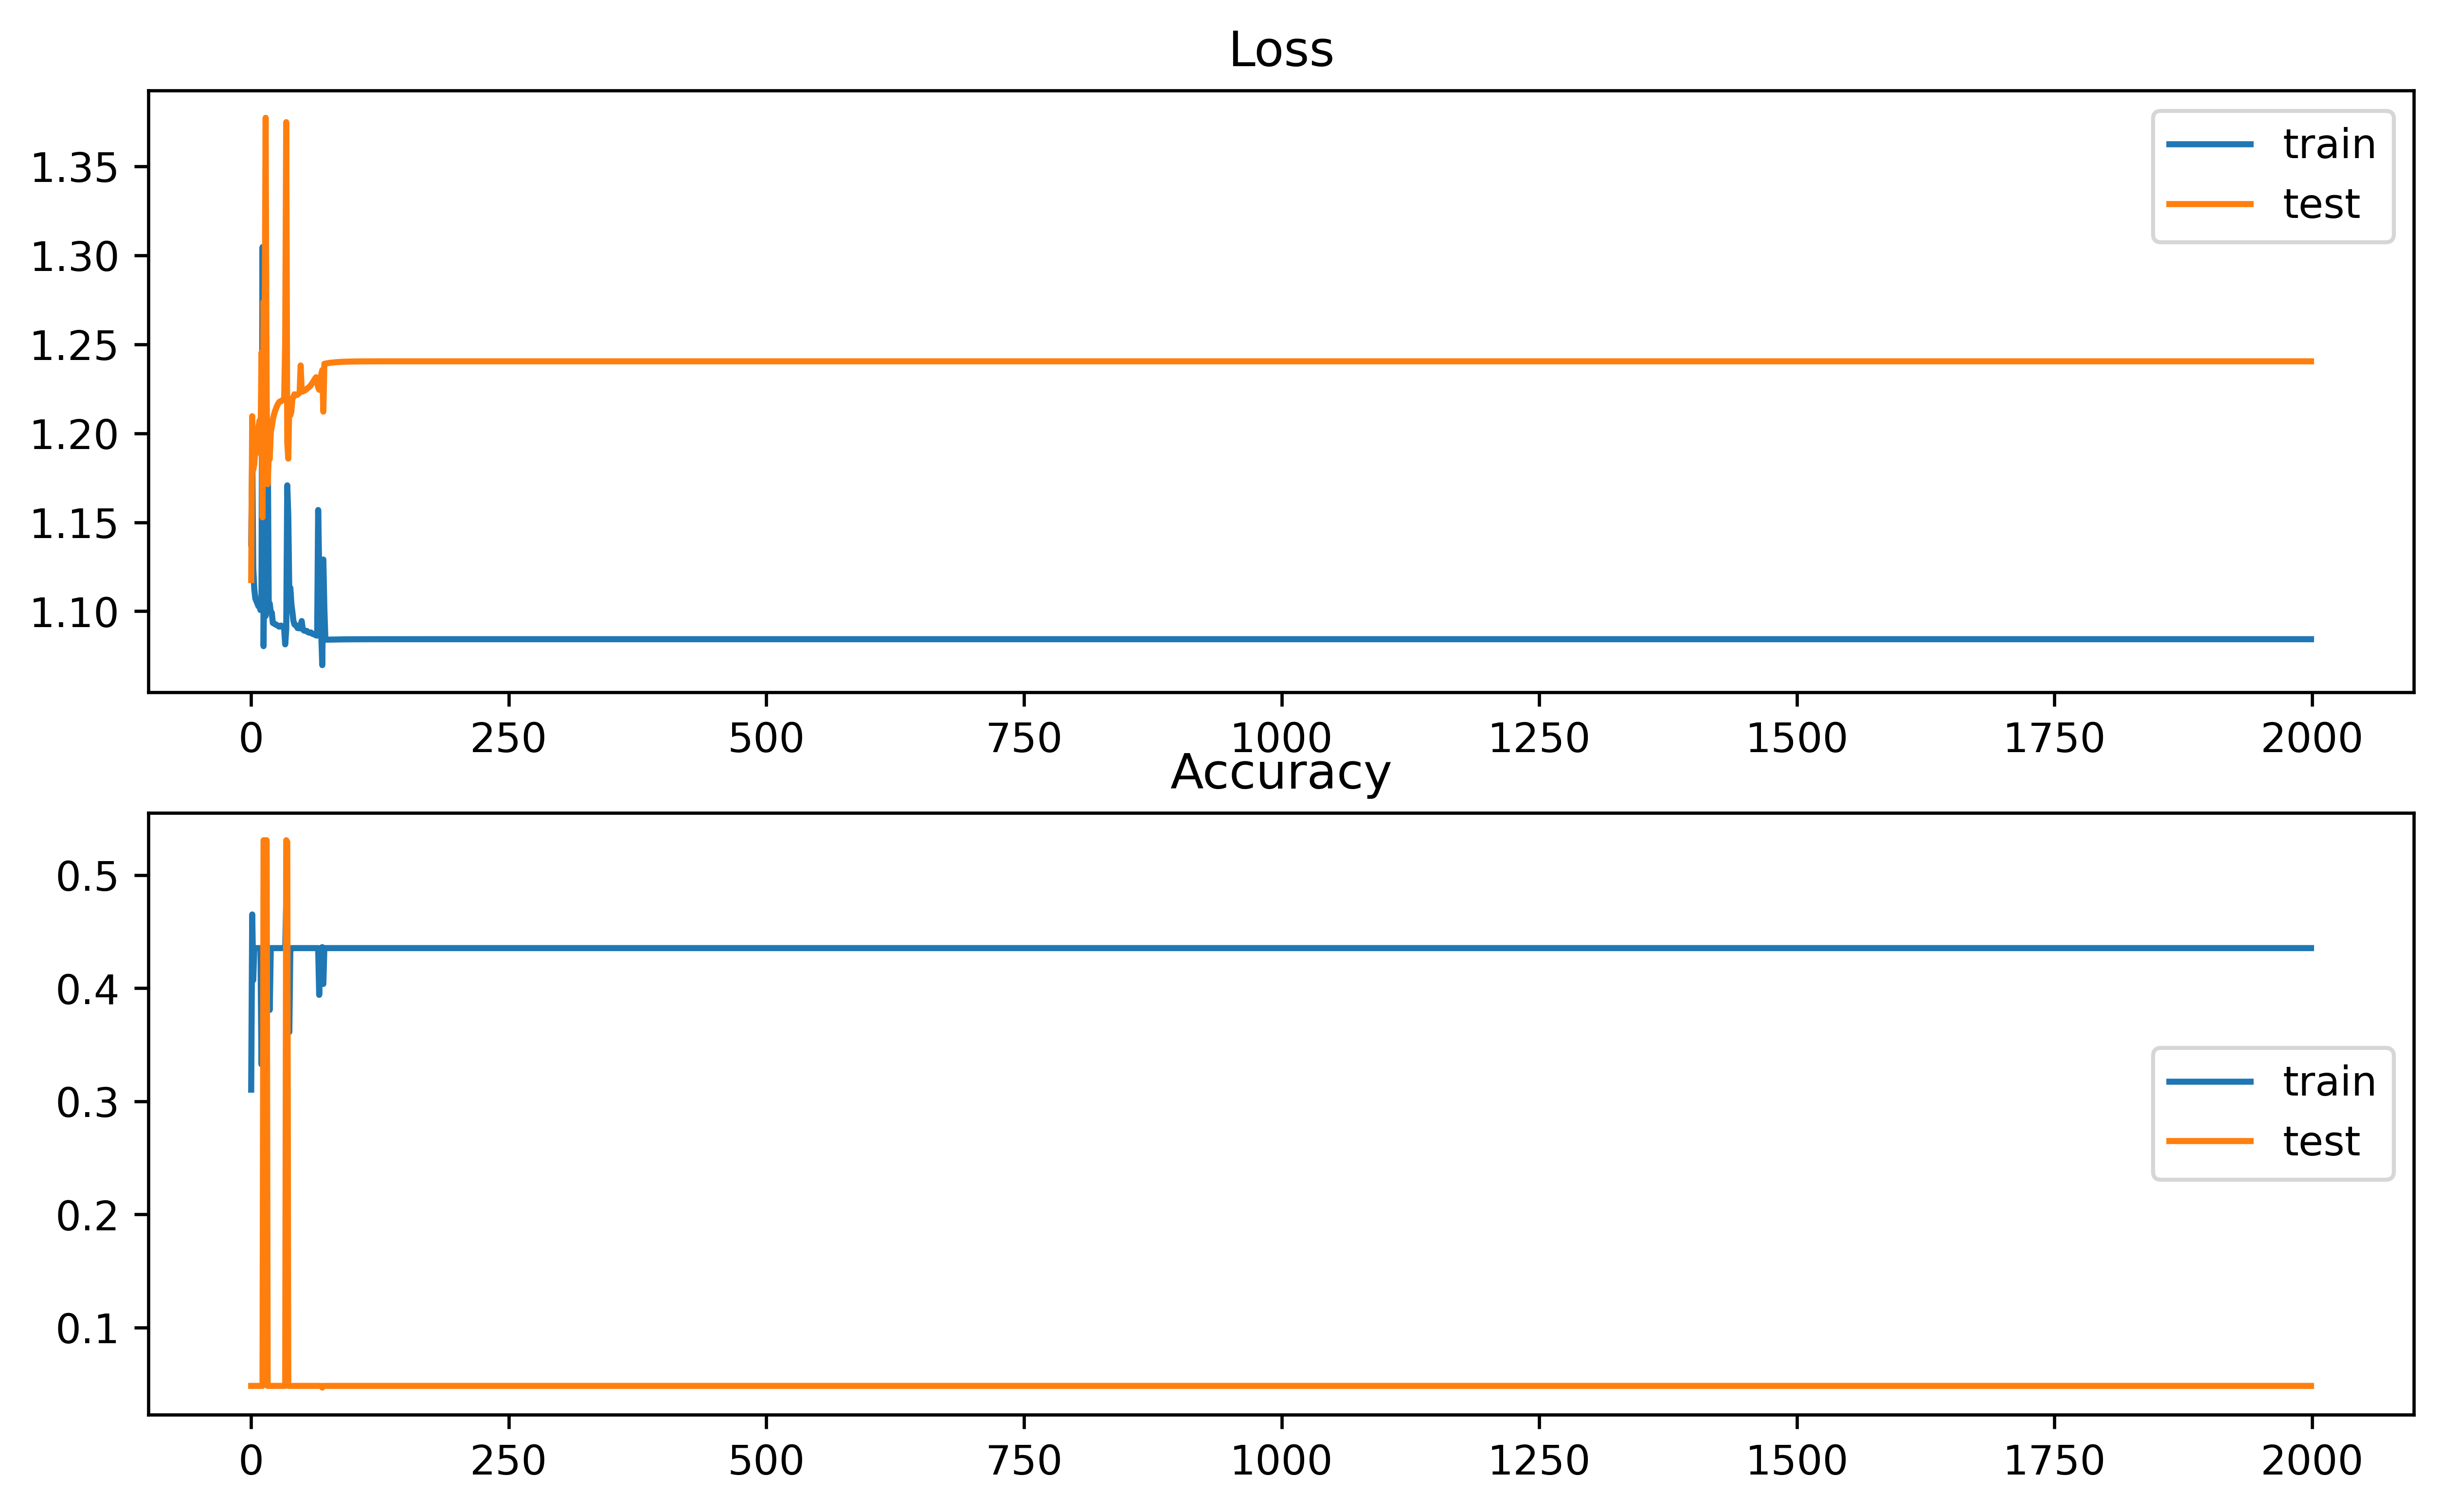

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 4.84%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       574
           1       0.05      1.00      0.09        66
           2       0.00      0.00      0.00       724

    accuracy                           0.05      1364
   macro avg       0.02      0.33      0.03      1364
weighted avg       0.00      0.05      0.00      1364

diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
[0.04838709677419355, 0.08354430379746836, 0.0, 0.103125, 0.0, 0.09230769230769231, 0.12721127999873966]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------
SMOTETomek
-----------------------------------------------
Train on 7126 samples, validate on 1364 samples
Epoch 1/2000
7104/7126 [============================>.] - ETA: 0s - loss: 1.0281 - accuracy: 0.5108

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7126/7126 [==============================] - 31s 4ms/sample - loss: 1.0273 - accuracy: 0.5123 - val_loss: 1.3135 - val_accuracy: 0.0484
Epoch 2/2000
7126/7126 [==============================] - 5s 636us/sample - loss: 1.1401 - accuracy: 0.2854 - val_loss: 1.2573 - val_accuracy: 0.0484
Epoch 3/2000
7126/7126 [==============================] - 5s 636us/sample - loss: 1.1049 - accuracy: 0.2957 - val_loss: 1.4674 - val_accuracy: 0.0484
Epoch 4/2000
7126/7126 [==============================] - 4s 594us/sample - loss: 1.0694 - accuracy: 0.3522 - val_loss: 4.3093 - val_accuracy: 0.0484
Epoch 5/2000
7126/7126 [==============================] - 5s 660us/sample - loss: 1.2321 - accuracy: 0.3132 - val_loss: 1.2352 - val_accuracy: 0.0484
Epoch 6/2000
7126/7126 [==============================] - 4s 595us/sample - loss: 1.1121 - accuracy: 0.2975 - val_loss: 1.3569 - val_accuracy: 0.0484
Epoch 7/2000
7126/7126 [==============================] - 4s 575us/sample - loss: 1.1360 - accuracy: 0.3163 - val_

In [ ]:
for i in range(len(method)):
  print(method[i])
  print('-----------------------------------------------')
  train_set[i] = train_set[i].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  test = test.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  train_x,train_y,test_x,test_y = get_newtraintest(train_set[i],test)
  myLSTM = lstm_model(train_x)
  yahtnew,ansnew = doLSTM(myLSTM,train_x,train_y,test_x,test_y,601)
  #result_lstm.append(ansnew)
  np.save('ponzi_LSTM'+ method[i],np.array(ansnew))
  print('-----------------------------------------------')

In [23]:
Lmethod=['SMOTETomek','TomekLinks']

RandomOverSampler
-----------------------------------------------
Train on 8406 samples, validate on 1364 samples
Epoch 1/2000
8288/8406 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.5081

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8406/8406 [==============================] - 8s 936us/sample - loss: 1.0339 - accuracy: 0.5150 - val_loss: 1.2415 - val_accuracy: 0.0484
Epoch 2/2000
8406/8406 [==============================] - 2s 254us/sample - loss: 1.1189 - accuracy: 0.3534 - val_loss: 1.3453 - val_accuracy: 0.0484
Epoch 3/2000
8406/8406 [==============================] - 2s 246us/sample - loss: 1.1288 - accuracy: 0.3182 - val_loss: 1.2948 - val_accuracy: 0.0484
Epoch 4/2000
8406/8406 [==============================] - 2s 248us/sample - loss: 1.1190 - accuracy: 0.3963 - val_loss: 1.2622 - val_accuracy: 0.0484
Epoch 5/2000
8406/8406 [==============================] - 2s 245us/sample - loss: 1.0162 - accuracy: 0.4921 - val_loss: 1.3784 - val_accuracy: 0.0484
Epoch 6/2000
8406/8406 [==============================] - 2s 254us/sample - loss: 1.0590 - accuracy: 0.4362 - val_loss: 1.7319 - val_accuracy: 0.0484
Epoch 7/2000
8406/8406 [==============================] - 2s 258us/sample - loss: 1.0981 - accuracy: 0.3633 - val

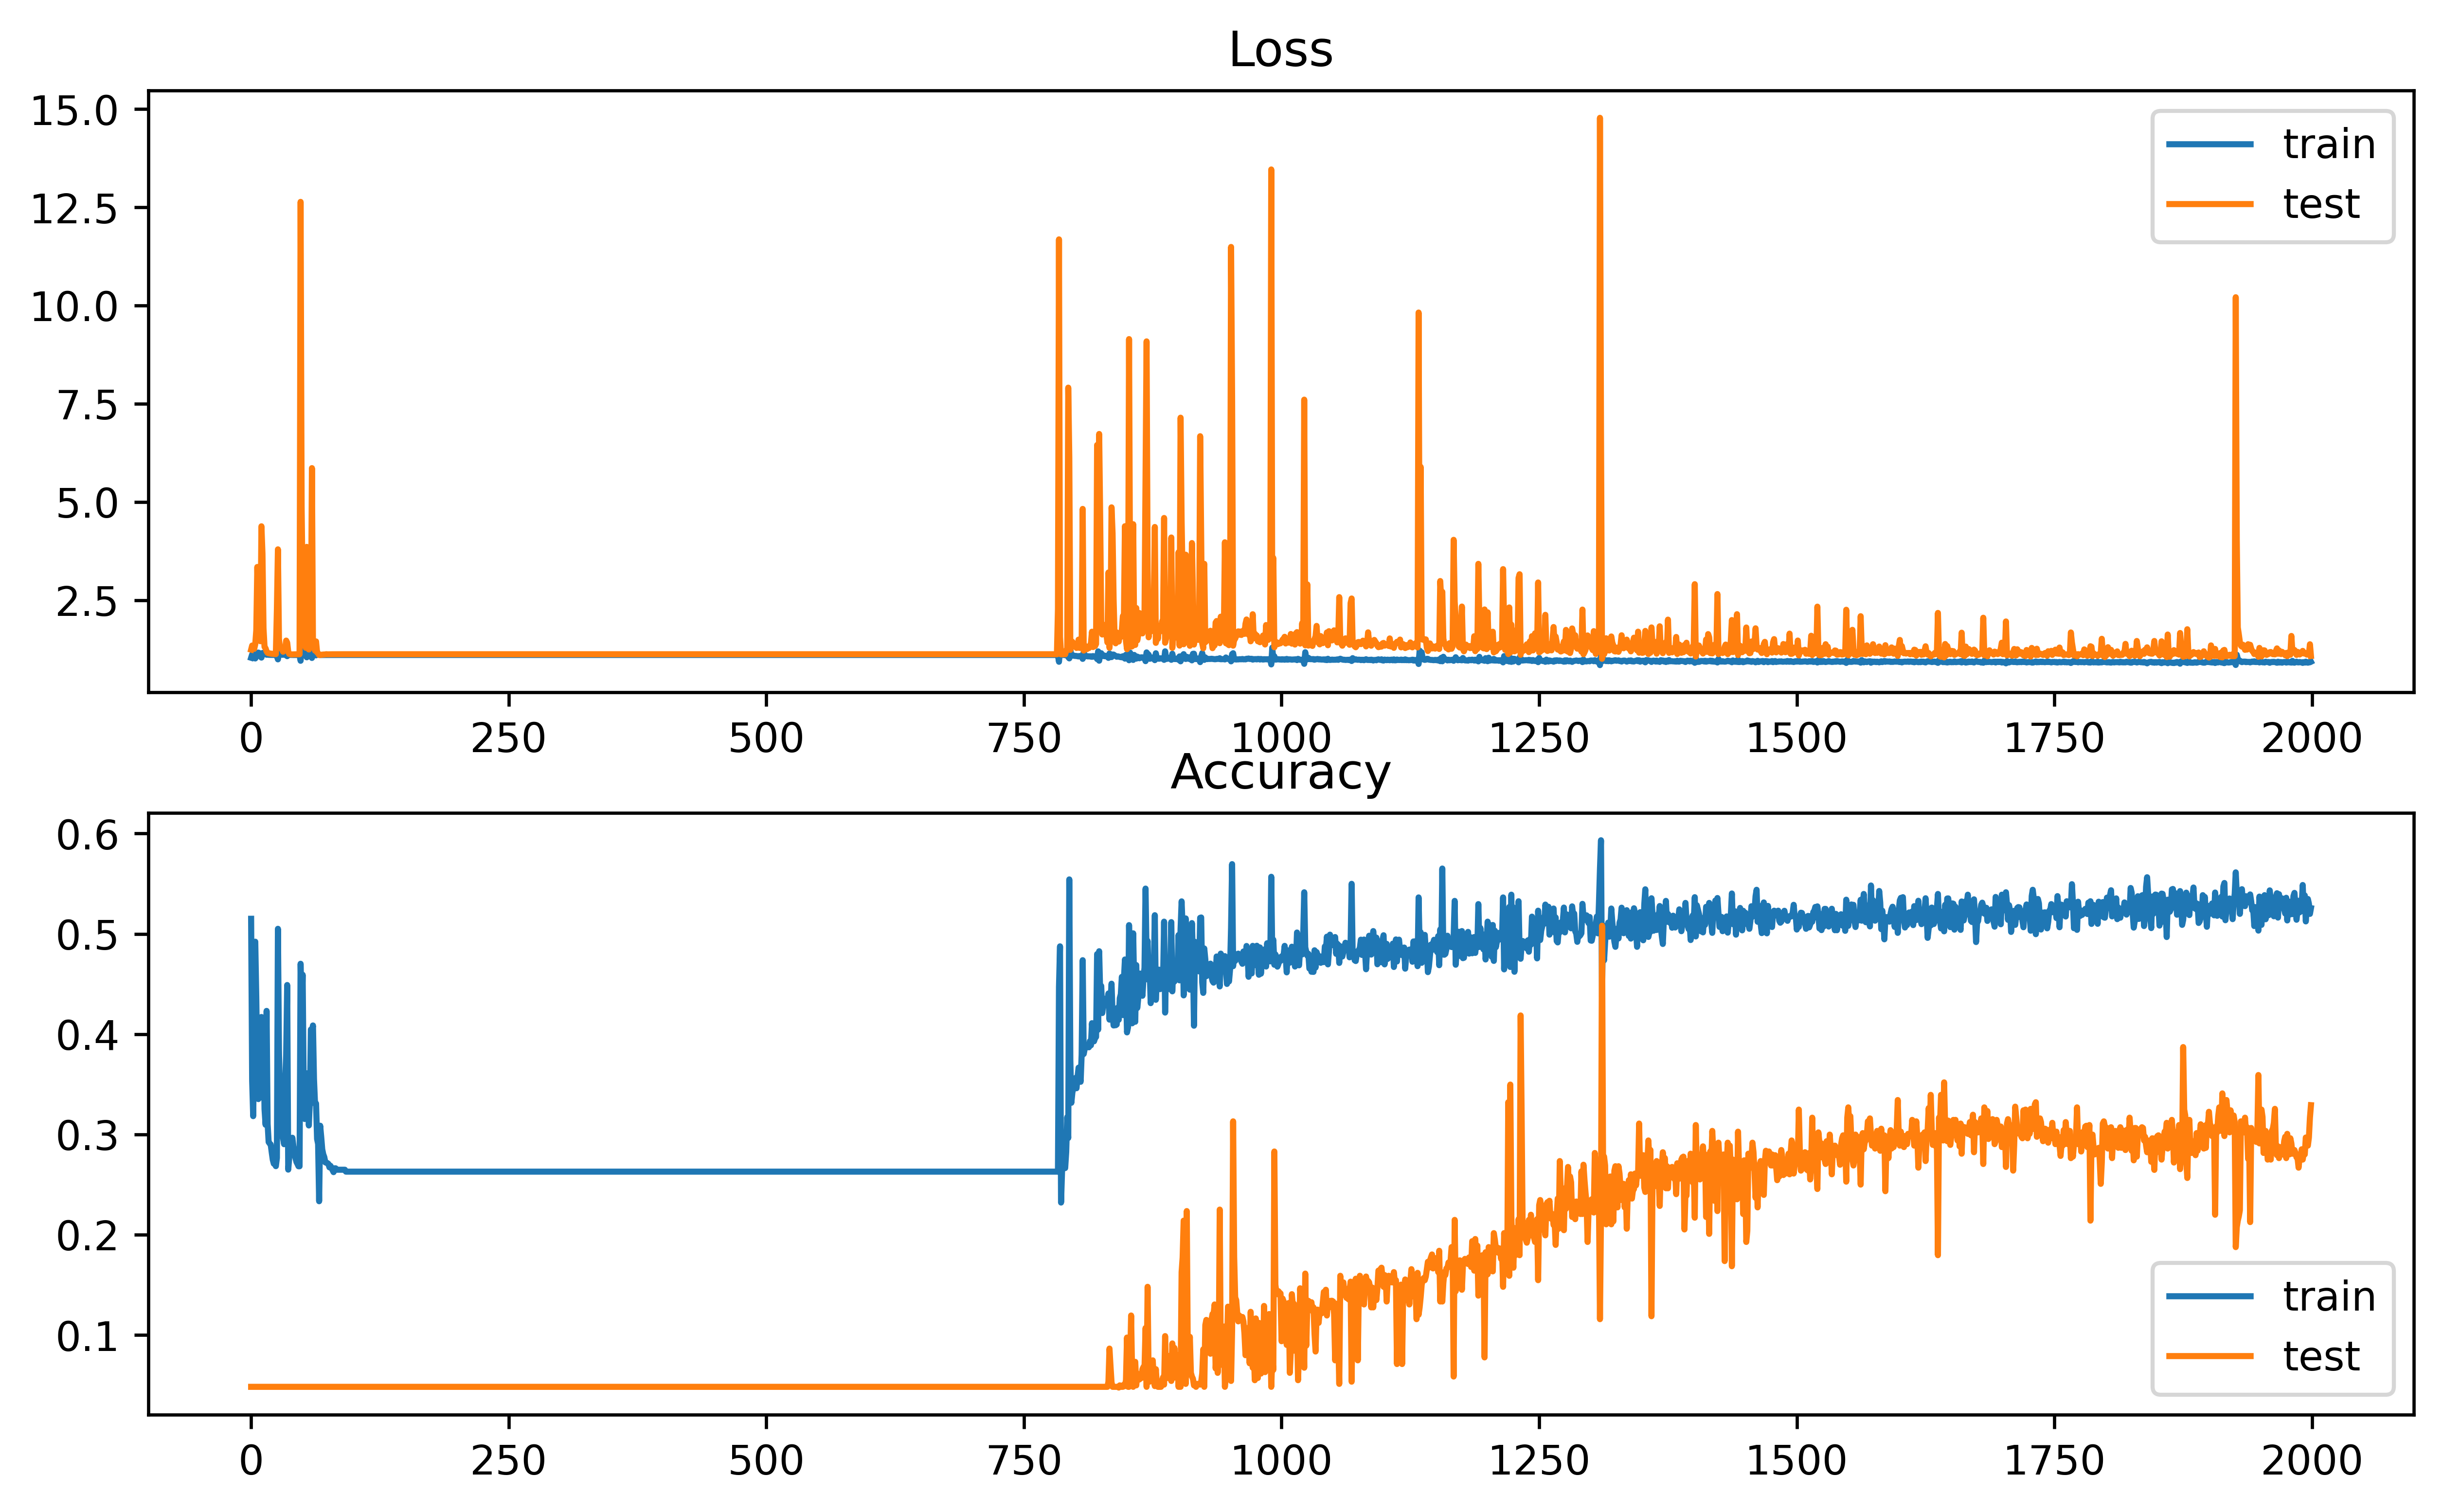

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 32.92%
              precision    recall  f1-score   support

           0       0.93      0.26      0.41       574
           1       0.05      0.70      0.10        66
           2       0.75      0.35      0.48       724

    accuracy                           0.33      1364
   macro avg       0.58      0.44      0.33      1364
weighted avg       0.79      0.33      0.43      1364

diagnostic index: 0.8107063240018013
F1 score : 0.39603960396039606
Accuracy: 0.3291788856304985
sensitivity: 0.379746835443038
specificity: 0.259581881533101
negative prediction ratio: 0.23317683881064163
positive prediction ratio: 0.41379310344827586
diagnostic index: 0.8107063240018013
F1 score : 0.39603960396039606
Accuracy: 0.3291788856304985
sensitivity: 0.379746835443038
specificity: 0.259581881533101
negative prediction ratio: 0.23317683881064163
positive prediction ratio: 0.41379310344827586
[0.3291788856304985, 0.379746835443038, 0.259581881533101, 0.41379310344827586, 0.23317683881064

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8406/8406 [==============================] - 11s 1ms/sample - loss: 0.9899 - accuracy: 0.5431 - val_loss: 1.6180 - val_accuracy: 0.0484
Epoch 2/2000
8406/8406 [==============================] - 3s 308us/sample - loss: 1.1591 - accuracy: 0.2888 - val_loss: 1.2647 - val_accuracy: 0.0484
Epoch 3/2000
8406/8406 [==============================] - 3s 310us/sample - loss: 1.1260 - accuracy: 0.3628 - val_loss: 1.2581 - val_accuracy: 0.0484
Epoch 4/2000
8406/8406 [==============================] - 3s 318us/sample - loss: 1.1410 - accuracy: 0.2892 - val_loss: 1.2201 - val_accuracy: 0.0484
Epoch 5/2000
8406/8406 [==============================] - 3s 329us/sample - loss: 1.1118 - accuracy: 0.3242 - val_loss: 1.2367 - val_accuracy: 0.0484
Epoch 6/2000
8406/8406 [==============================] - 3s 312us/sample - loss: 1.1247 - accuracy: 0.2930 - val_loss: 1.1784 - val_accuracy: 0.0484
Epoch 7/2000
8406/8406 [==============================] - 3s 309us/sample - loss: 1.1169 - accuracy: 0.2702 - val_

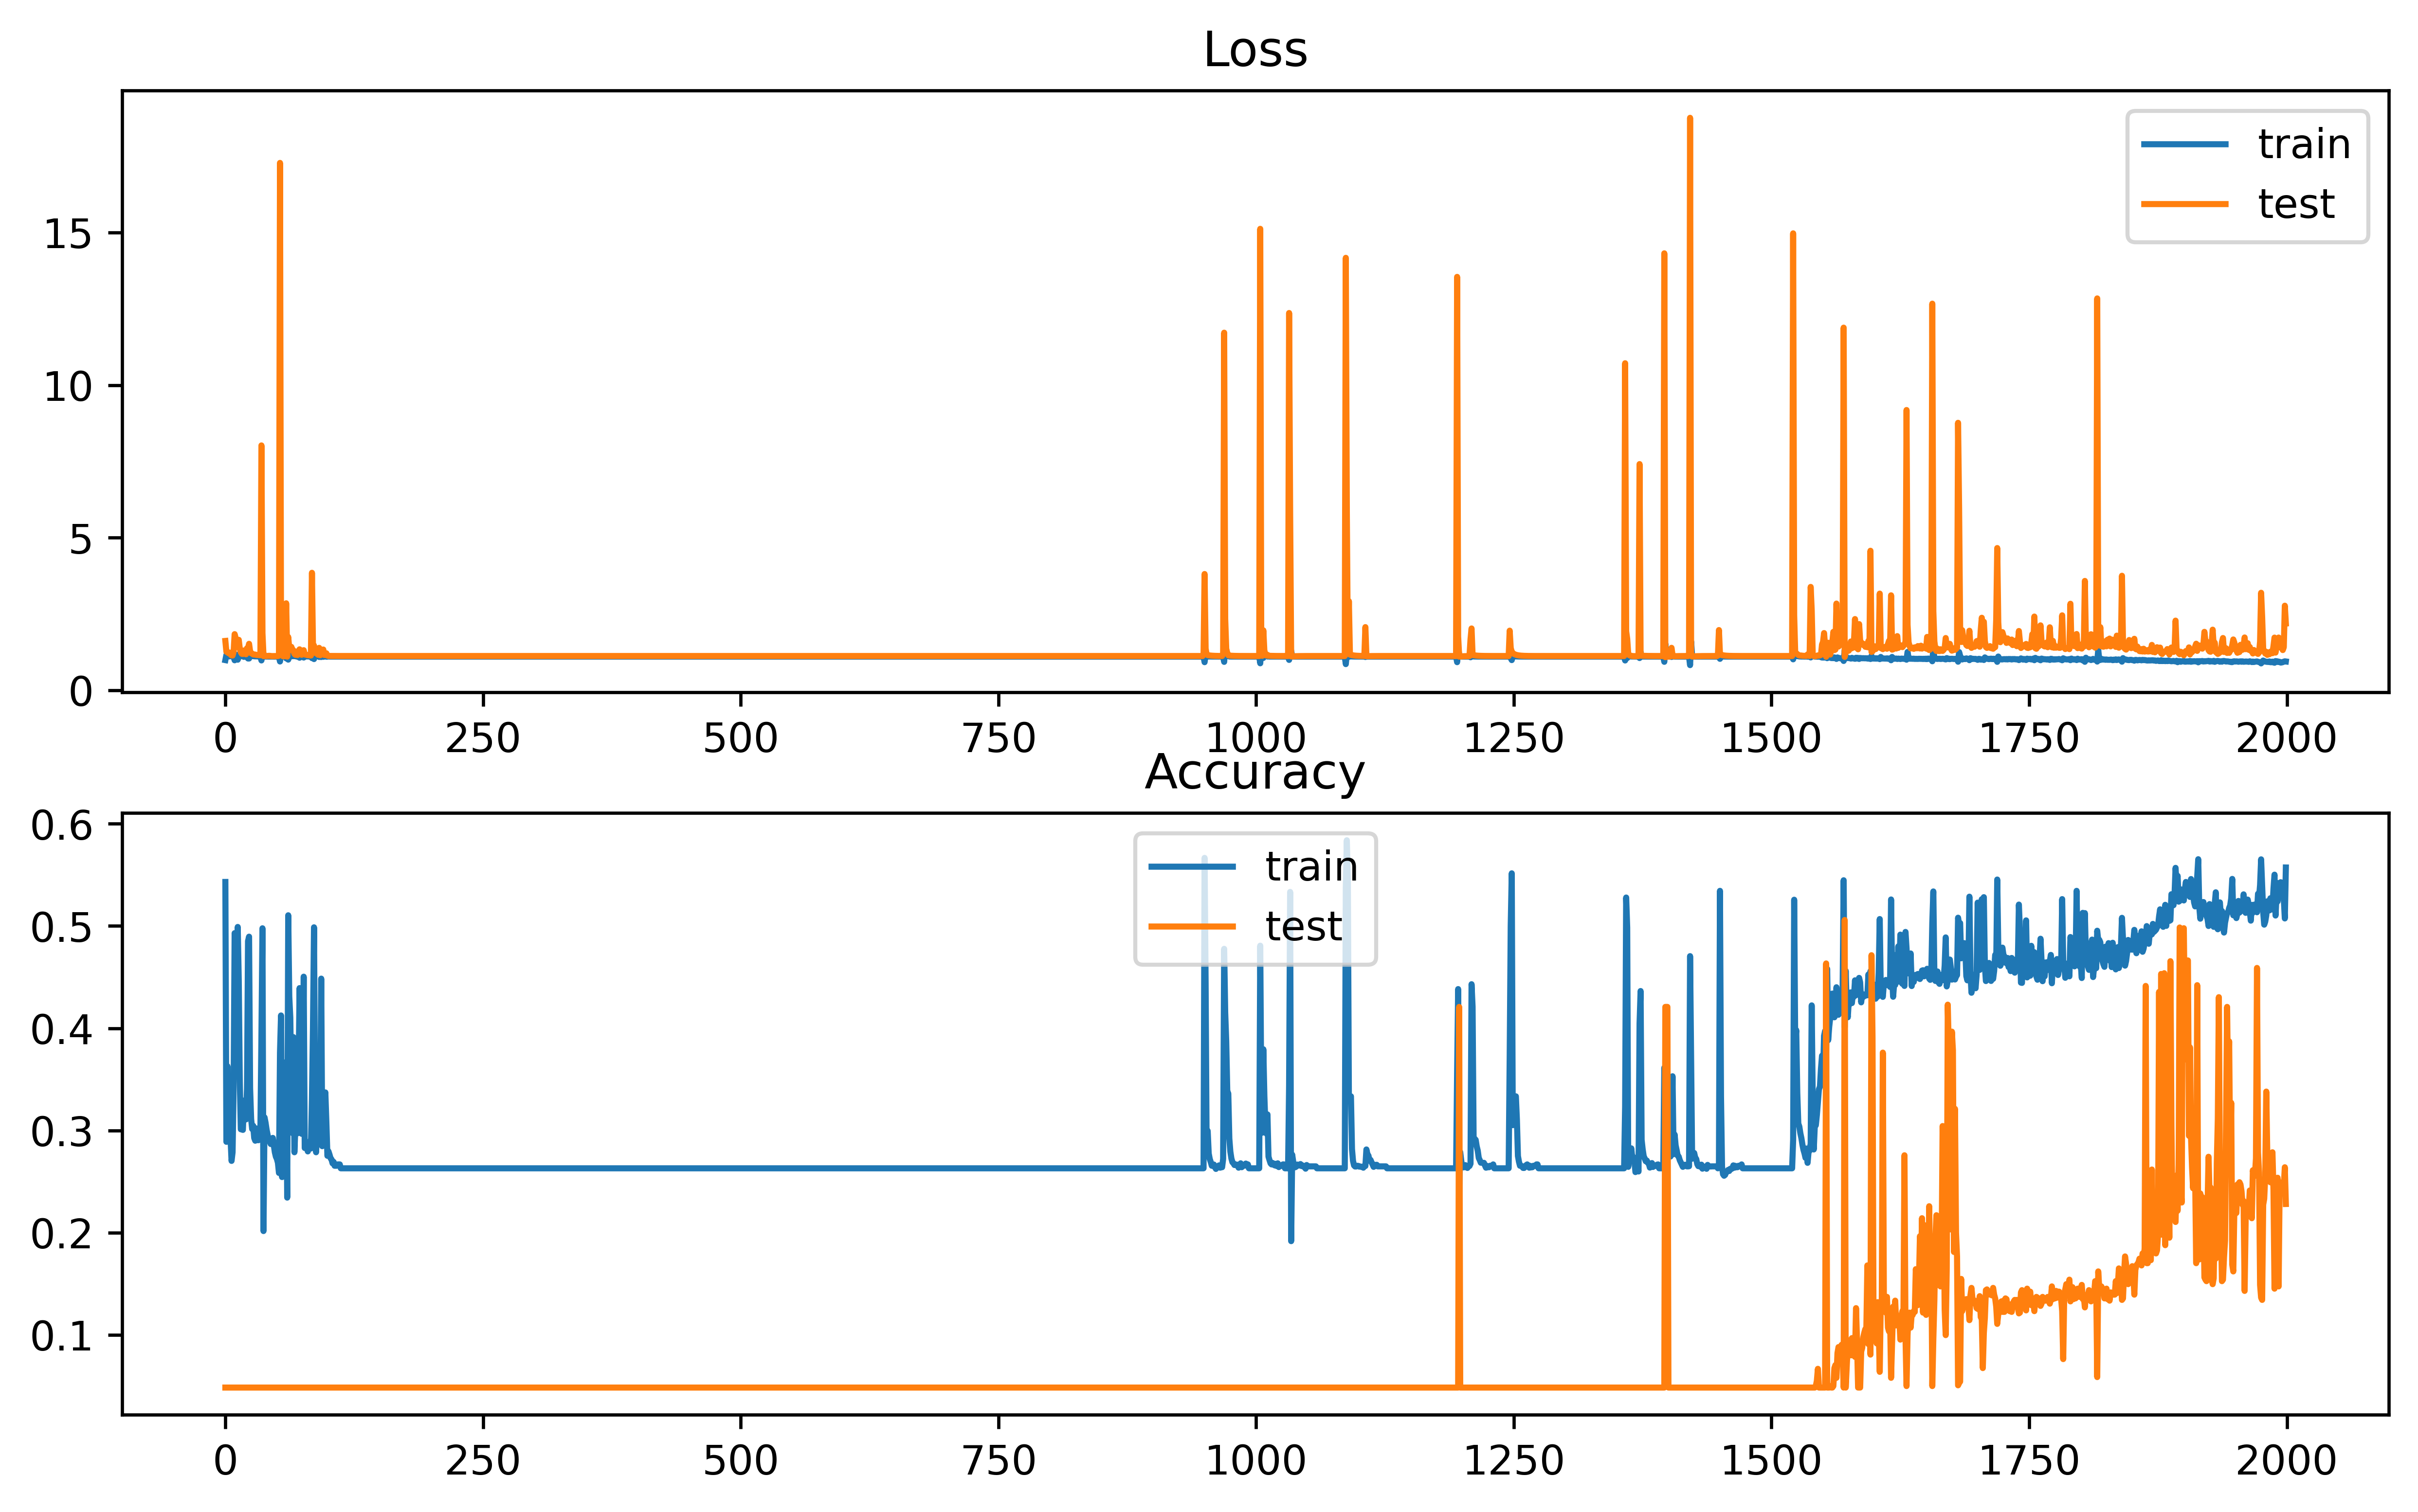

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 22.80%
              precision    recall  f1-score   support

           0       0.72      0.13      0.22       574
           1       0.05      0.85      0.10        66
           2       0.79      0.25      0.38       724

    accuracy                           0.23      1364
   macro avg       0.52      0.41      0.23      1364
weighted avg       0.72      0.23      0.30      1364

diagnostic index: 0.576349386059545
F1 score : 0.31131458469587964
Accuracy: 0.2280058651026393
sensitivity: 0.3012658227848101
specificity: 0.12717770034843207
negative prediction ratio: 0.1168
positive prediction ratio: 0.32205683355886333
diagnostic index: 0.576349386059545
F1 score : 0.31131458469587964
Accuracy: 0.2280058651026393
sensitivity: 0.3012658227848101
specificity: 0.12717770034843207
negative prediction ratio: 0.1168
positive prediction ratio: 0.32205683355886333
[0.2280058651026393, 0.3012658227848101, 0.12717770034843207, 0.32205683355886333, 0.1168, 0.31131458469587964, 0.5763

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3532/3532 [==============================] - 15s 4ms/sample - loss: 1.1590 - accuracy: 0.3791 - val_loss: 1.1516 - val_accuracy: 0.0484
Epoch 2/2000
3532/3532 [==============================] - 2s 445us/sample - loss: 1.1189 - accuracy: 0.3313 - val_loss: 1.1521 - val_accuracy: 0.0484
Epoch 3/2000
3532/3532 [==============================] - 2s 452us/sample - loss: 1.1073 - accuracy: 0.4354 - val_loss: 1.1665 - val_accuracy: 0.0484
Epoch 4/2000
3532/3532 [==============================] - 2s 490us/sample - loss: 1.1036 - accuracy: 0.4354 - val_loss: 1.1763 - val_accuracy: 0.0484
Epoch 5/2000
3532/3532 [==============================] - 2s 499us/sample - loss: 1.1020 - accuracy: 0.4354 - val_loss: 1.1839 - val_accuracy: 0.0484
Epoch 6/2000
3532/3532 [==============================] - 2s 458us/sample - loss: 1.1001 - accuracy: 0.4354 - val_loss: 1.1901 - val_accuracy: 0.0484
Epoch 7/2000
3532/3532 [==============================] - 2s 468us/sample - loss: 1.1008 - accuracy: 0.4354 - val_

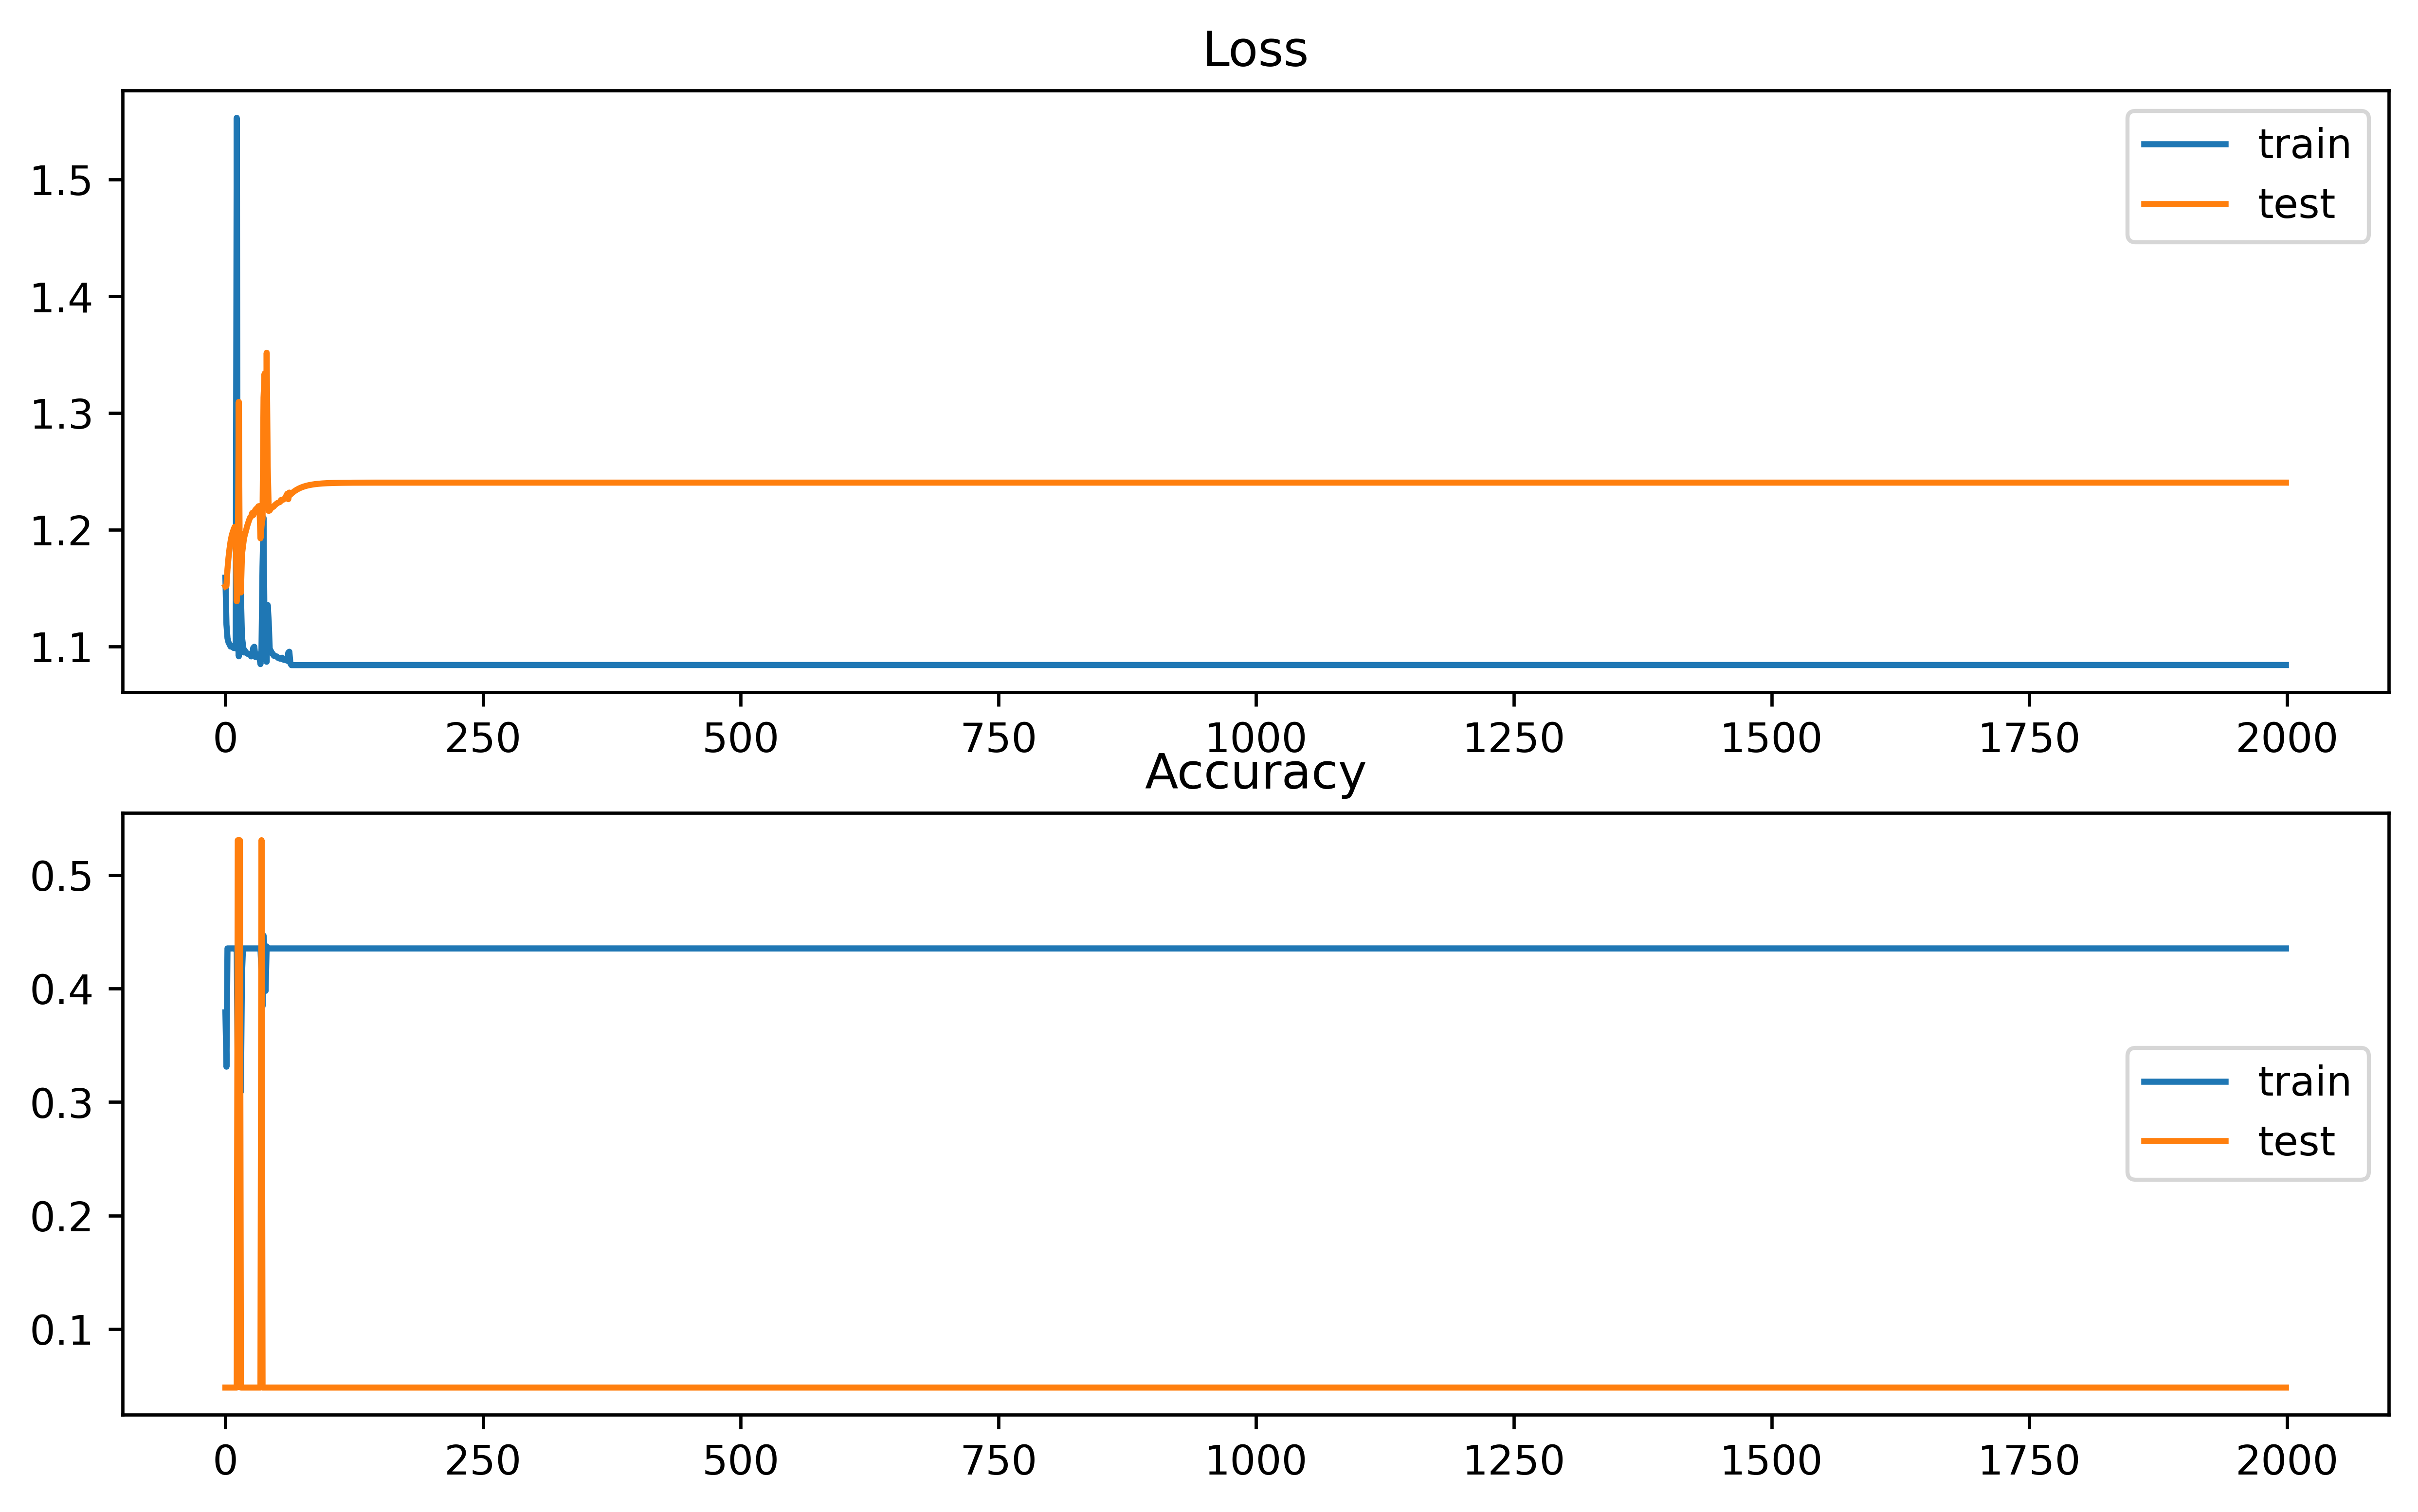

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 4.84%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       574
           1       0.05      1.00      0.09        66
           2       0.00      0.00      0.00       724

    accuracy                           0.05      1364
   macro avg       0.02      0.33      0.03      1364
weighted avg       0.00      0.05      0.00      1364

diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
[0.04838709677419355, 0.08354430379746836, 0.0, 0.103125, 0.0, 0.09230769230769231, 0.12721127999873966]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------
SMOTETomek
-----------------------------------------------
Train on 7126 samples, validate on 1364 samples
Epoch 1/2000
7040/7126 [============================>.] - ETA: 0s - loss: 1.0502 - accuracy: 0.4761

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7126/7126 [==============================] - 20s 3ms/sample - loss: 1.0485 - accuracy: 0.4825 - val_loss: 1.2045 - val_accuracy: 0.0484
Epoch 2/2000
7126/7126 [==============================] - 3s 416us/sample - loss: 1.1023 - accuracy: 0.3065 - val_loss: 1.2879 - val_accuracy: 0.0484
Epoch 3/2000
7126/7126 [==============================] - 3s 438us/sample - loss: 1.1250 - accuracy: 0.3386 - val_loss: 1.4808 - val_accuracy: 0.0484
Epoch 4/2000
7126/7126 [==============================] - 3s 452us/sample - loss: 1.0559 - accuracy: 0.3694 - val_loss: 3.6843 - val_accuracy: 0.0484
Epoch 5/2000
7126/7126 [==============================] - 3s 406us/sample - loss: 1.2325 - accuracy: 0.2929 - val_loss: 1.2230 - val_accuracy: 0.0484
Epoch 6/2000
7126/7126 [==============================] - 3s 443us/sample - loss: 1.1305 - accuracy: 0.2755 - val_loss: 1.1518 - val_accuracy: 0.0484
Epoch 7/2000
7126/7126 [==============================] - 3s 431us/sample - loss: 1.1077 - accuracy: 0.2582 - val_

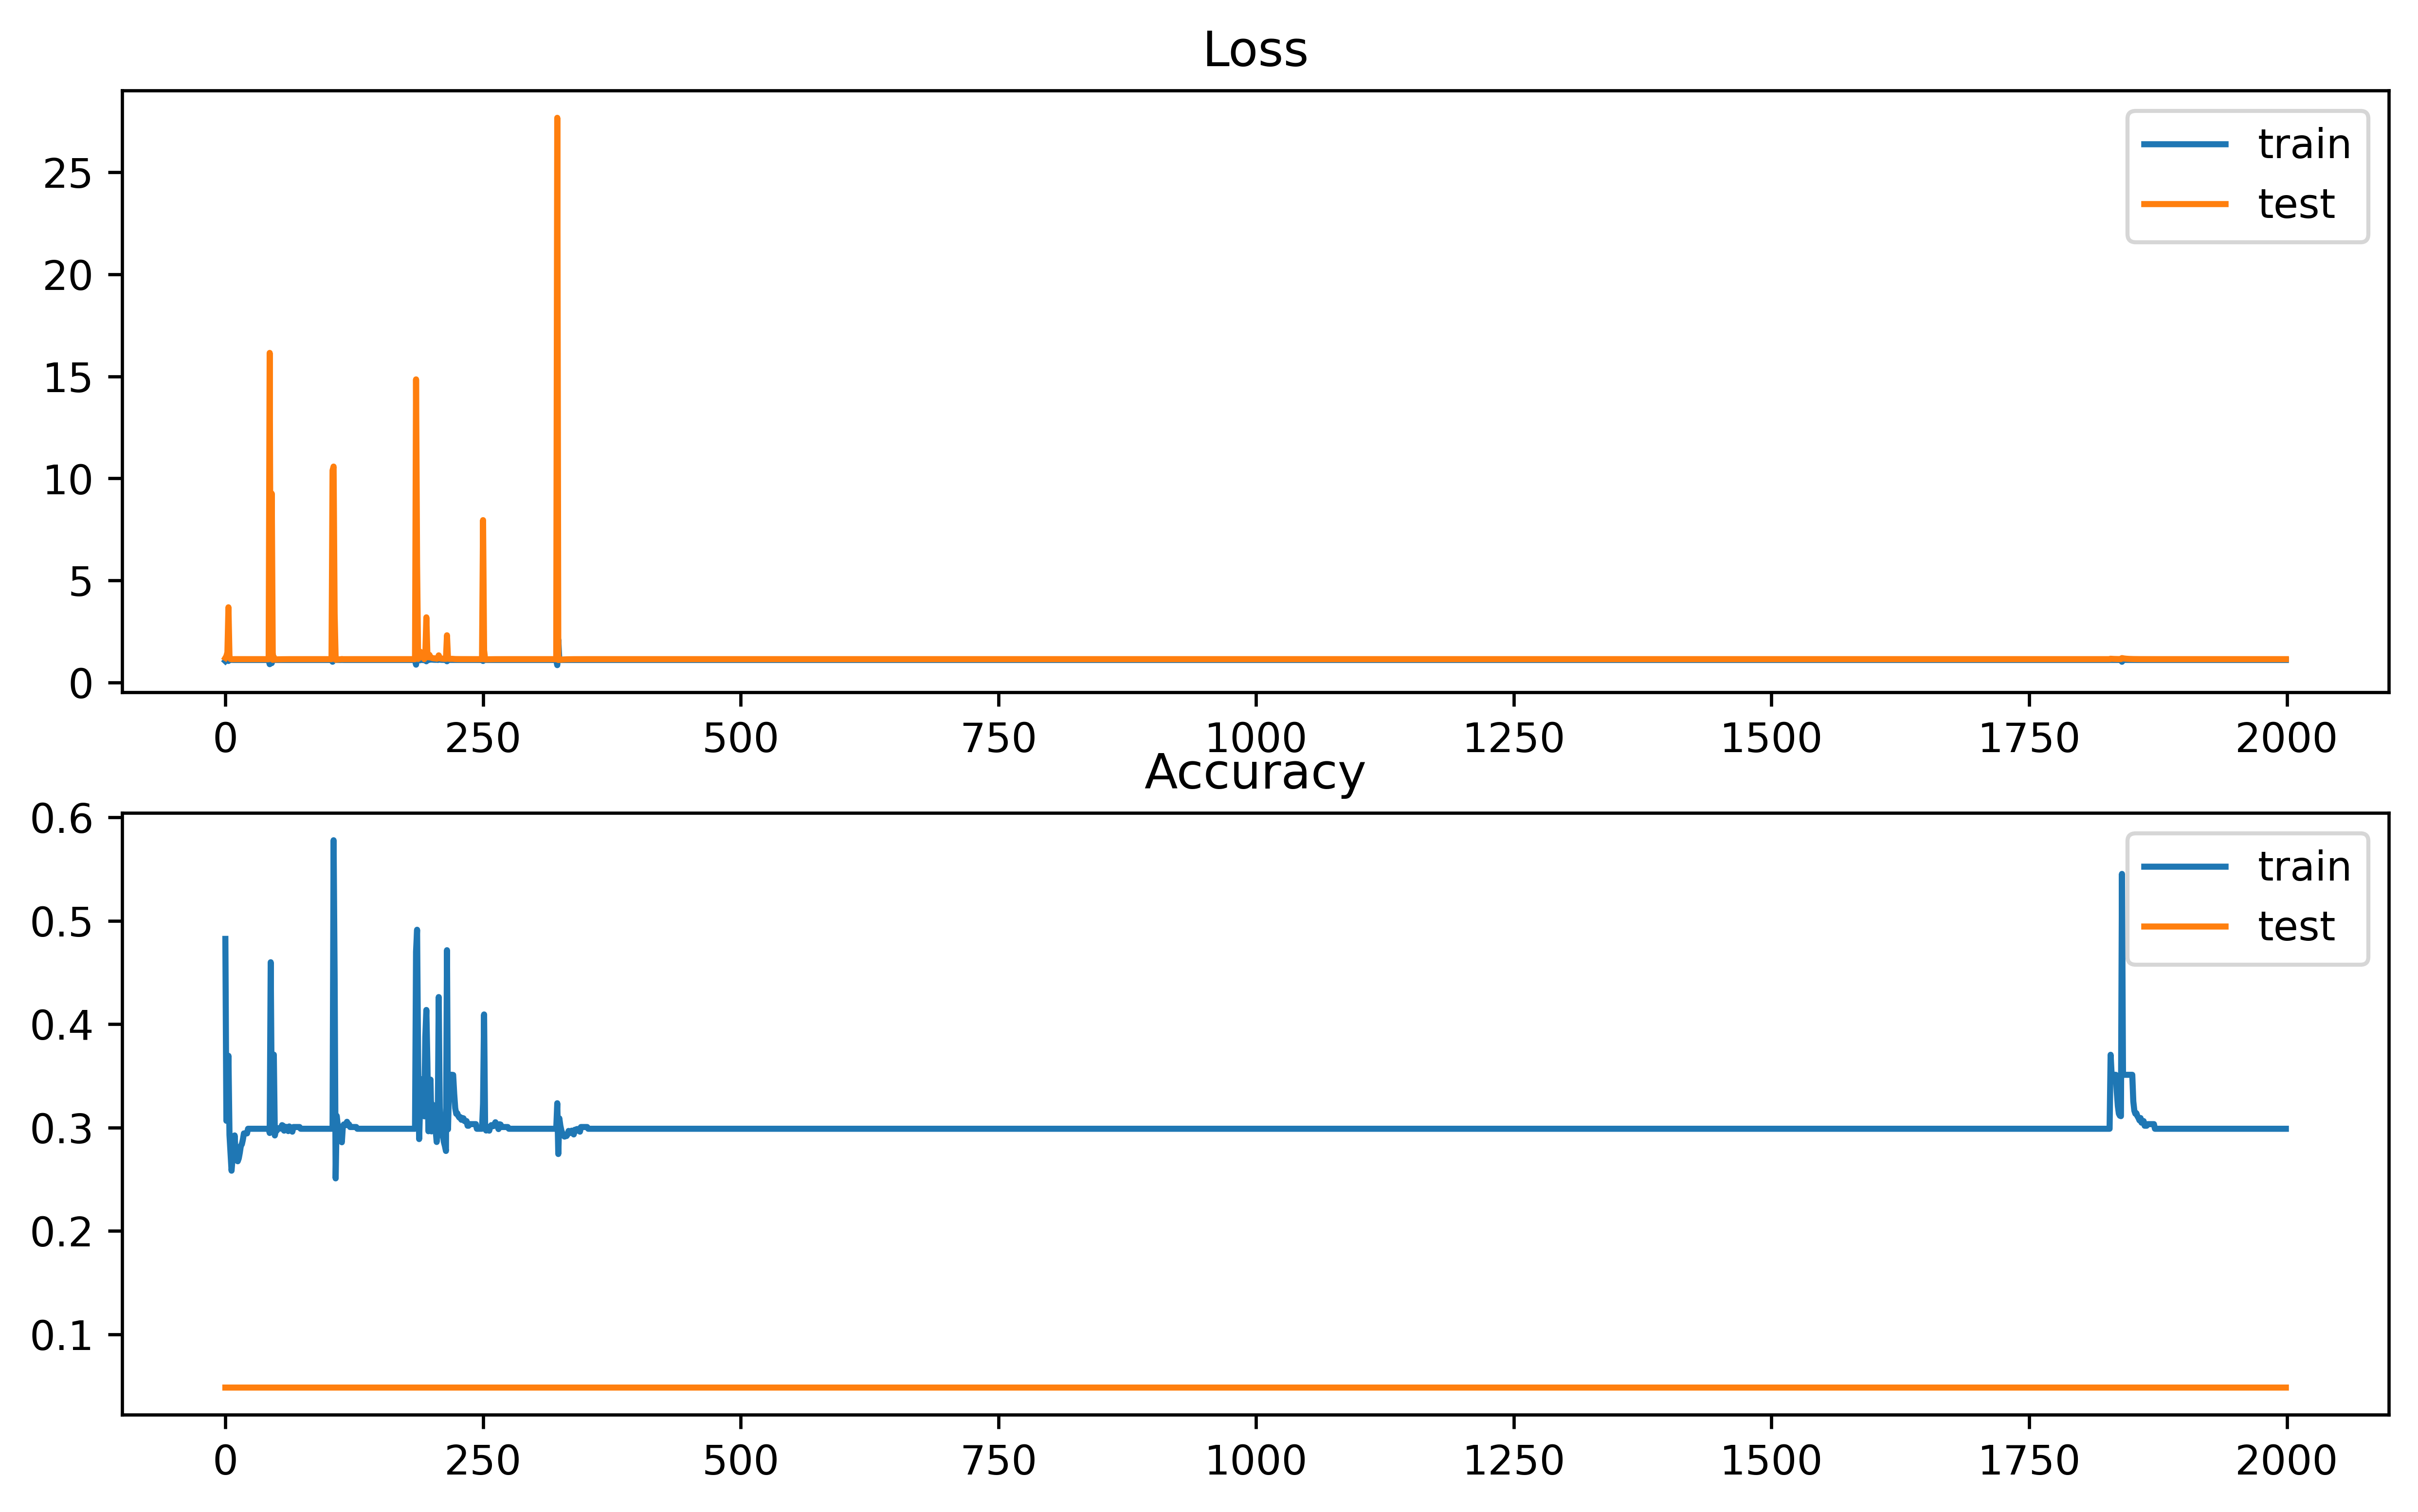

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 4.84%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       574
           1       0.05      1.00      0.09        66
           2       0.00      0.00      0.00       724

    accuracy                           0.05      1364
   macro avg       0.02      0.33      0.03      1364
weighted avg       0.00      0.05      0.00      1364

diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
diagnostic index: 0.12721127999873966
F1 score : 0.09230769230769231
Accuracy: 0.04838709677419355
sensitivity: 0.08354430379746836
specificity: 0.0
negative prediction ratio: 0.0
positive prediction ratio: 0.103125
[0.04838709677419355, 0.08354430379746836, 0.0, 0.103125, 0.0, 0.09230769230769231, 0.12721127999873966]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------
TomekLinks
-----------------------------------------------
Train on 4561 samples, validate on 1364 samples
Epoch 1/2000
4561/4561 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.5073

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4561/4561 [==============================] - 23s 5ms/sample - loss: 0.9016 - accuracy: 0.5073 - val_loss: 0.8475 - val_accuracy: 0.5308
Epoch 2/2000
4561/4561 [==============================] - 2s 461us/sample - loss: 0.8573 - accuracy: 0.5102 - val_loss: 0.8475 - val_accuracy: 0.5308
Epoch 3/2000
4561/4561 [==============================] - 2s 497us/sample - loss: 0.8545 - accuracy: 0.5052 - val_loss: 0.8467 - val_accuracy: 0.5308
Epoch 4/2000
4561/4561 [==============================] - 2s 449us/sample - loss: 0.8498 - accuracy: 0.5139 - val_loss: 0.8442 - val_accuracy: 0.5308
Epoch 5/2000
4561/4561 [==============================] - 2s 454us/sample - loss: 0.8441 - accuracy: 0.5251 - val_loss: 0.8453 - val_accuracy: 0.5367
Epoch 6/2000
4561/4561 [==============================] - 2s 480us/sample - loss: 0.8115 - accuracy: 0.6029 - val_loss: 0.8672 - val_accuracy: 0.5850
Epoch 7/2000
4561/4561 [==============================] - 2s 505us/sample - loss: 0.7690 - accuracy: 0.6336 - val_

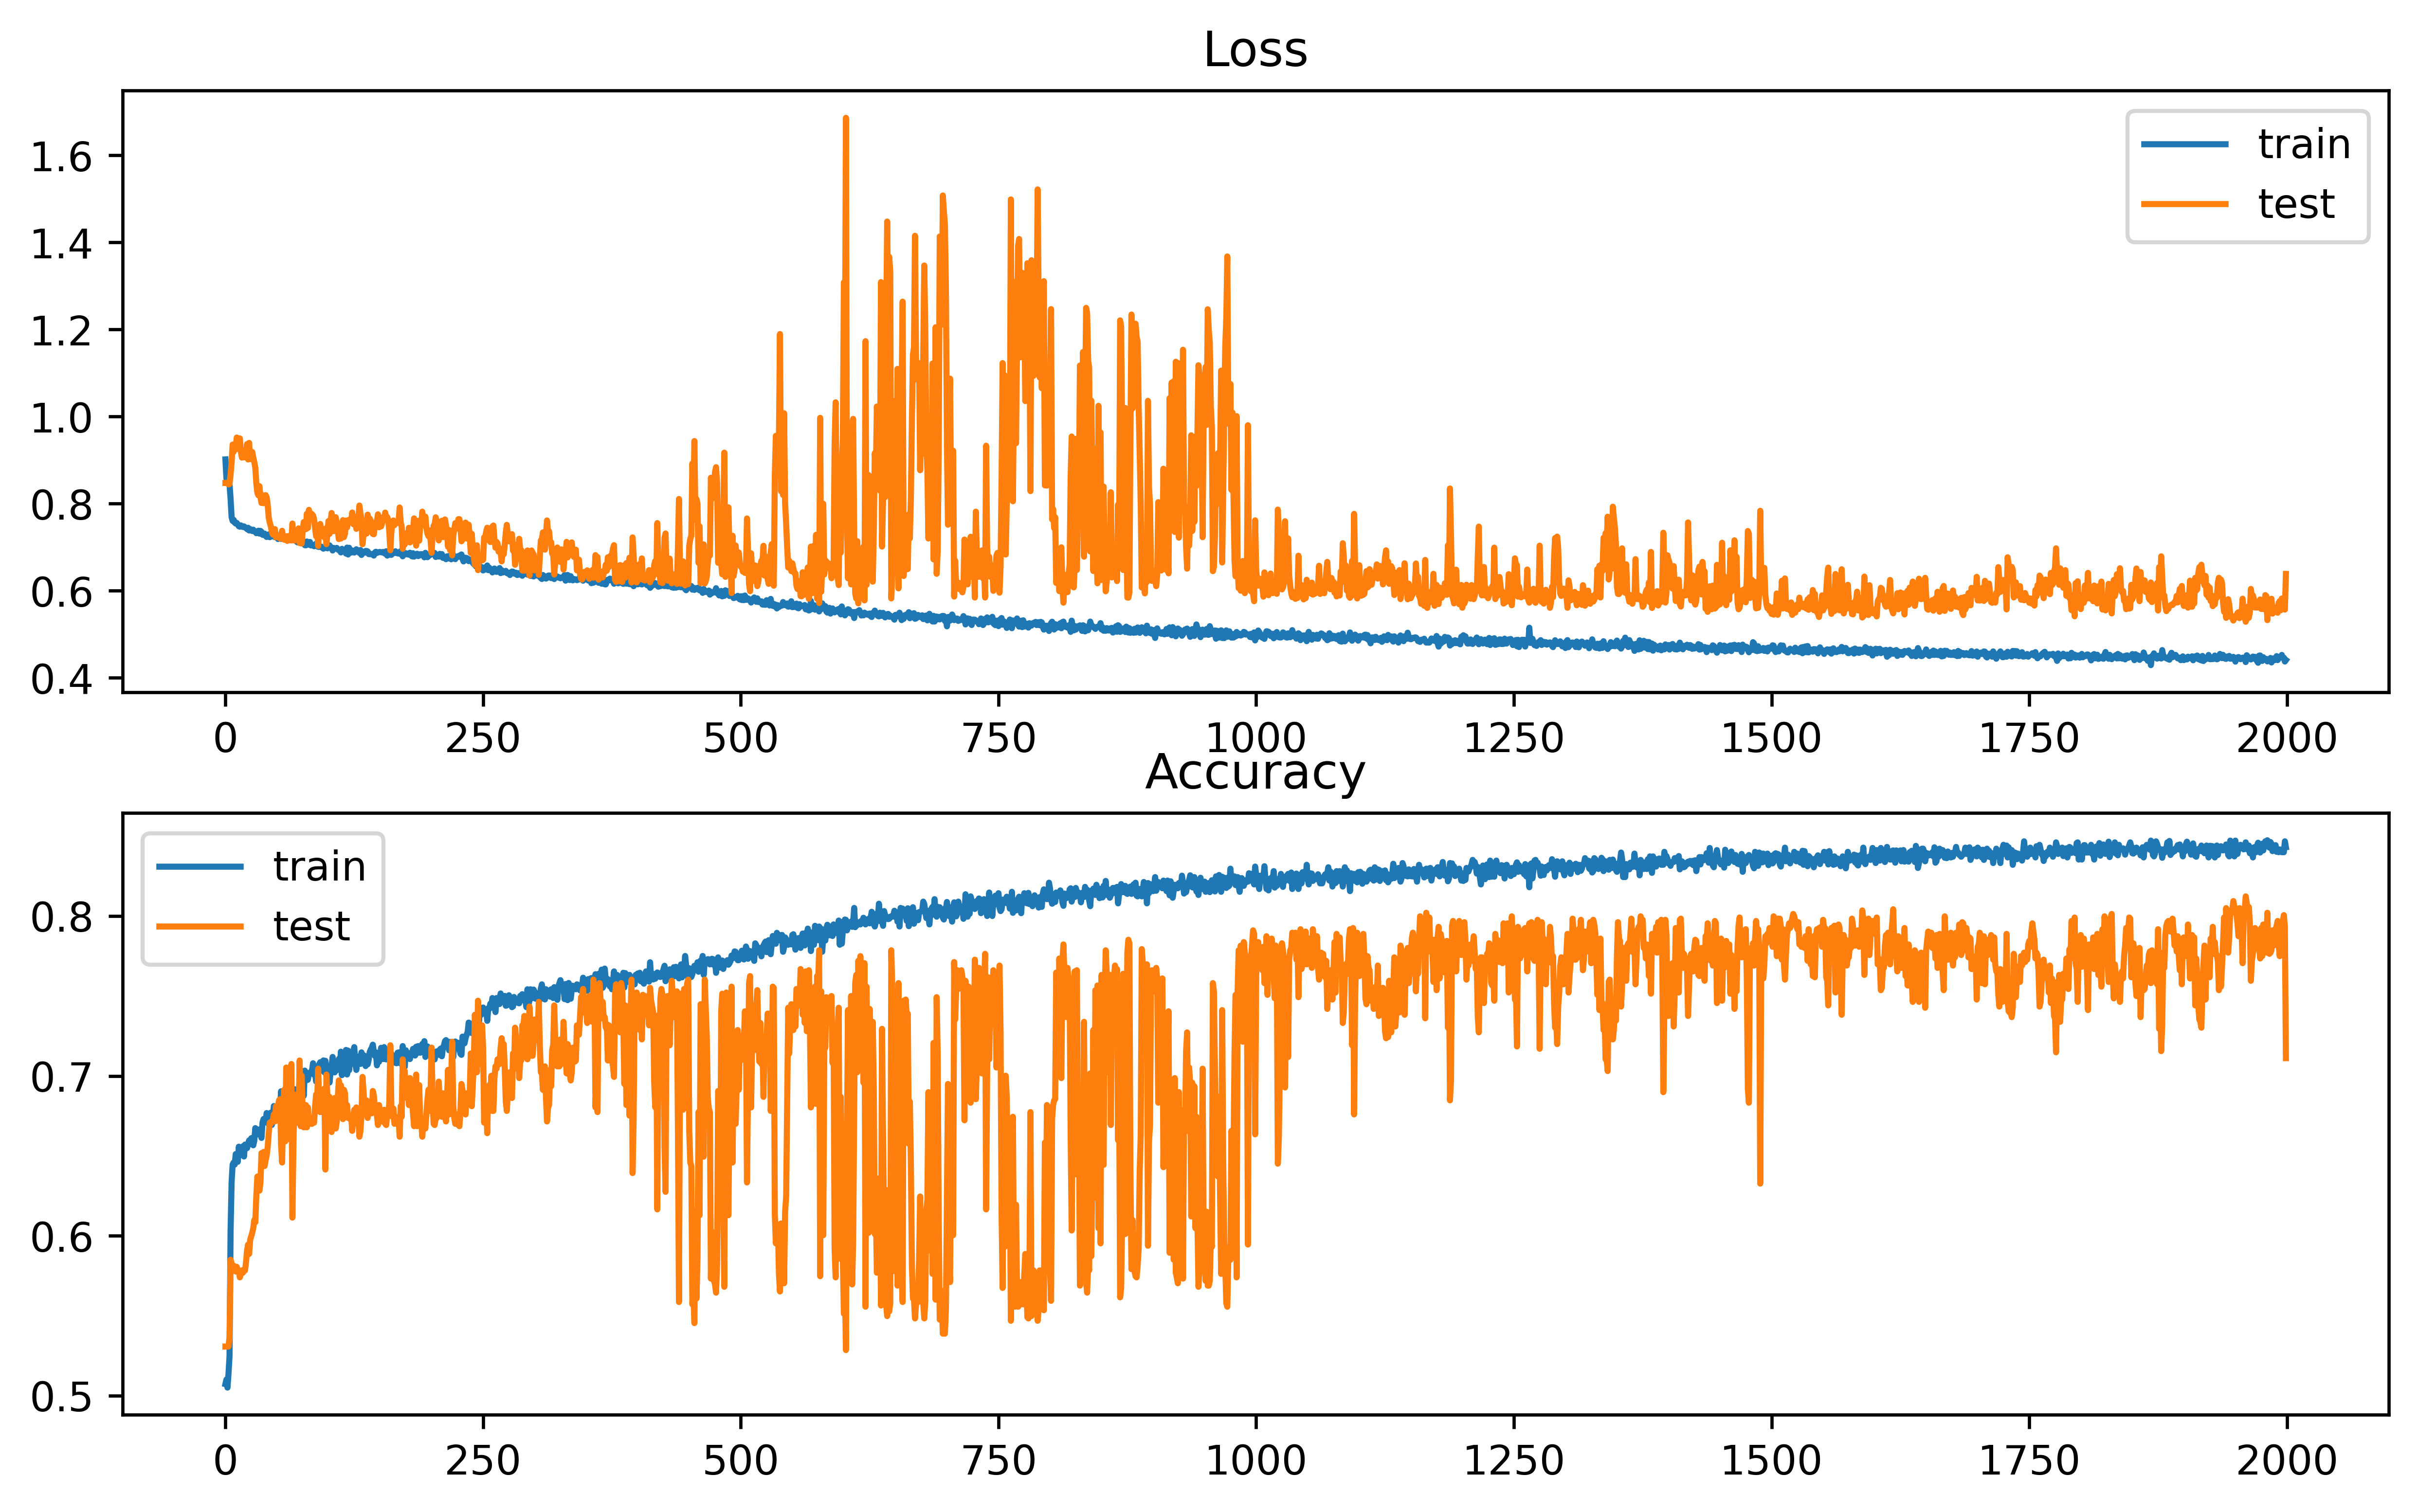

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy: 71.11%
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       574
           1       0.71      0.08      0.14        66
           2       0.79      0.67      0.73       724

    accuracy                           0.71      1364
   macro avg       0.72      0.53      0.53      1364
weighted avg       0.72      0.71      0.70      1364

diagnostic index: 1.5638710202723907
F1 score : 0.714078374455733
Accuracy: 0.7111436950146628
sensitivity: 0.6227848101265823
specificity: 0.8327526132404182
negative prediction ratio: 0.615979381443299
positive prediction ratio: 0.8367346938775511
diagnostic index: 1.5638710202723907
F1 score : 0.714078374455733
Accuracy: 0.7111436950146628
sensitivity: 0.6227848101265823
specificity: 0.8327526132404182
negative prediction ratio: 0.615979381443299
positive prediction ratio: 0.8367346938775511
[0.7111436950146628, 0.6227848101265823, 0.8327526132404182, 0.8367346938775511, 0.615979381443299, 0.

In [24]:
for i in range(len(method)):
  print(method[i])
  print('-----------------------------------------------')
  train_set[i] = train_set[i].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  test = test.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  train_x,train_y,test_x,test_y = get_newtraintest(train_set[i],test)
  myLSTM = lstm_model(train_x)
  yahtnew,ansnew = doLSTM(myLSTM,train_x,train_y,test_x,test_y,601)
  #result_lstm.append(ansnew)
  np.save('ponzi_LSTM'+ method[i],np.array(ansnew))
  print('-----------------------------------------------')